In [1]:

from sklearnex import patch_sklearn
patch_sklearn()
import pickle
import numpy as np
import pandas as pd

import helper
import utils
import re
import lightgbm as lgb
from xgboost import XGBClassifier

from scipy.spatial import distance
from sklearn.utils.class_weight import compute_class_weight

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split


import os

from sklearn import metrics

from scipy.stats import entropy

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
from matplotlib.transforms import Affine2D

import warnings

import operator

warnings.filterwarnings('ignore')


font = {'weight' : 'normal',
        'size'   : 25}

matplotlib.rc('font', **font)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

import warnings

warnings.filterwarnings('ignore')
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning)

os.environ["PYTHONWARNINGS"] = "ignore::UserWarning"

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
def get_model(name):

    if name == 'LR':
        clf = LogisticRegression()
        return clf

    elif name == 'LR-Balanced':
        clf = LogisticRegression(class_weight='balanced')
        return clf

    elif name == 'SVM':
        svm = LinearSVC()
        clf = CalibratedClassifierCV(svm) 
        return clf

    elif name == 'SVM-Balanced':
        svm = LinearSVC(class_weight='balanced')
        clf = CalibratedClassifierCV(svm)
        return clf

    elif name == 'XGBoost':
        clf = XGBClassifier()
        return clf

    elif name == 'LightGBM':
        clf = lgb.LGBMClassifier()
        return clf
        
    elif name == 'LightGBM-Balanced':
        clf = lgb.LGBMClassifier(class_weight='balanced')
        return clf

    elif name == 'RandomForest':
        clf = RandomForestClassifier()
        return clf

    elif name == 'RandomForest-Balanced':
        clf = RandomForestClassifier(class_weight = 'balanced')
        return clf

    elif name == 'GradientBoosting':
        clf = GradientBoostingClassifier()
        return clf

    else:
        return "Error - No Model"
        
    

In [3]:
names = ['acc',
               'auc', 
               'S1_acc', 
               'S0_acc',
               'worst_acc',
               'delta_acc',
               'S1_auc',
               'S0_auc',
               'worst_auc',
               'delta_auc',
               'spd',
               'tpr_s1',
               'tpr_s0', 
               'tprd',
               'fpr_s1',
               'fpr_s0', 
               'fprd',
                'fnr_s1',
                'fnr_s0',
                'fnrd',
                'f1',
               'f1_macro',
               'f1_micro',
               'f1_weighted']

In [4]:
def get_data(name):

    if name == 'ny_race':
        data = pd.read_csv('./dataset/adult_ny_race.csv').drop('SEX', axis=1)
        data = data[~data['year'].isin([2019])]
        years = sorted(data.year.unique())

        return data, years

    elif name == 'ca_race':
        data = pd.read_csv('./dataset/adult_ca_race.csv')
        data = data[~data['year'].isin([2019])]
        years = sorted(data.year.unique())

        return data, years

    elif name == 'toxicity_raw':
        data = pd.read_csv('./dataset/identity_bias_df_glove_embedding.csv')
        years = sorted(data.year.unique())
       
        return data, years

    elif name == 'toxicity_synthetic':
        data = pd.read_csv('./dataset/identity_bias_df_glove_embedding.csv')
        years = sorted(data.year.unique())
        modified_data = create_synthetic_data(data)
       
        return modified_data, years


    elif name == 'mimic_sex':
        data = pd.read_csv('./dataset/los_3_task.csv').drop('race', axis=1)
        data = data.rename({'sex': 'sensitive'}, axis=1)
        data = data.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
        data = data.loc[:,~data.columns.duplicated()].copy()
        years = sorted(data.year.unique())
        
        return data, years

    elif name == 'claim_party':
        data = pd.read_csv('./dataset/cleaned_claim_glove.csv')
        data = data[~data['year'].isin([1980])]
        years = sorted(data.year.unique())
        
        return data, years

    elif name == 'HateExplain_aae':
        data = pd.read_csv('./dataset/hate_explain_aae_glove.csv')
        years = sorted(data.year.unique())
        
        return data, years

### Modeling

In [5]:
def vanilla(df, name):

    years = sorted(df.year.unique())
    train = df[df['year'] == years[1]]
    train = train.sample(frac=1)
    X_train, y_train = train.drop(['year', 'y'], axis=1), train['y'].values
    
    model = get_model(name)
    
    model.fit(X_train, y_train)
    
    all_results = []
    for i in years[2:]:
        
        test = df[df['year'] == i]
        test = test.sample(frac=1)
    
        X_test, y_test = test.drop(['year', 'y'], axis = 1), test['y'].values
    
        pred = model.predict(X_test)
        prob = model.predict_proba(X_test)[:, 1]
    
        results = utils.get_results(X_test['sensitive'].values, y_test, pred, prob)
        all_results.append(results)
    
    final_results = pd.DataFrame(all_results)
    final_results.columns = names

    return final_results

In [6]:
def fairness(df, name):

    years = sorted(df.year.unique())
    train = df[df['year'] == years[1]]
    train = train.sample(frac=1)

    instance_weights = utils.kamiran(train, 'sensitive', 'y', verbose=True)
    
    X_train, y_train = train.drop(['year', 'y'], axis=1), train['y'].values
    
    model = get_model(name)
    
    model.fit(X_train, y_train, sample_weight = instance_weights)
    
    all_results = []
    for i in years[2:]:
        
        test = df[df['year'] == i]
        test = test.sample(frac=1)
    
        X_test, y_test = test.drop(['year', 'y'], axis = 1), test['y'].values
    
        pred = model.predict(X_test)
        prob = model.predict_proba(X_test)[:, 1]
    
        results = utils.get_results(X_test['sensitive'].values, y_test, pred, prob)
        all_results.append(results)
    
    final_results = pd.DataFrame(all_results)
    final_results.columns = names

    return final_results

In [7]:
def DA(df, name, oracle=None, fairness=None):

    'DA'
    
    years = sorted(df.year.unique())
    
    all_results = []
    estimation_errors = []
    
    for i in range(2, len(years)):
        train = df[df['year'] == years[i-1]]
        train = train.sample(frac=1)
        
        test = df[df['year'] == years[i]]
        test = test.sample(frac=1)
        
        
        #P(S)
        test_sensitive_0, test_sensitive_1 = test['sensitive'].value_counts(normalize=True)[0], test['sensitive'].value_counts(normalize=True)[1]

        if oracle:
            new_rate = utils.get_joint(test)
        else:
            # Estimation
            p_y_given_S1, p_y_given_S0, S1_prevalence, S0_prevalence = utils.estimate_test_custom(train, test)
        
            p_y_and_S0 = p_y_given_S0 * test_sensitive_0
            p_y_and_S1 = p_y_given_S1 * test_sensitive_1
        
            new_rate = np.array([[p_y_and_S0[0],p_y_and_S1[0]],[p_y_and_S0[1], p_y_and_S1[1]]])

        # Estimation Errors 
        eps = distance.jensenshannon(new_rate, utils.get_joint(test), base=2).sum()
        estimation_errors.append(eps)
        
        new_train = helper.generate_sample_joint_shift(train, new_rate, train.shape[0])
        
        X_train, y_train = new_train.drop(['year', 'y'], axis=1), new_train['y'].values
        X_test, y_test = test.drop(['year','y'], axis=1), test['y'].values
        
        model = get_model(name)

        if fairness:
            instance_weights = utils.kamiran(new_train, 'sensitive', 'y', verbose=True)
            model.fit(X_train, y_train, sample_weight = instance_weights)

        else:
            model.fit(X_train, y_train)
        
        pred = model.predict(X_test)
        prob = model.predict_proba(X_test)[:,1]
        
        results = utils.get_results(X_test['sensitive'].values, y_test, pred, prob)
        all_results.append(results)
        
    final_results = pd.DataFrame(all_results)
    final_results.columns = names
    final_results['estimation_error'] = estimation_errors
        
    return final_results

In [8]:
def Almuzaini(df, name):
        
    years = sorted(df.year.unique())
    
    all_results = []
    estimation_errors = []
    
    ## Start from 2010 as a train and 2012 as a test
    for i in range(2, len(years)):
        
        # Train and Test split
        train = df[df['year'] == years[i-1]] # 2011
        train = train.sample(frac=1)
        
        test = df[df['year'] == years[i]] # 2012
        test = test.sample(frac=1)
    
        
        # Estimated Test - estimation of 2012 is based on 2010 and 2011
        joint_next = utils.moving_average(df, [years[i-2],years[i-1]])

        joint_current = utils.get_joint(train)

        instance_weights_current = utils.kamiran(train, 'sensitive', 'y', verbose=True)

        W_next = utils.get_weight_from_joint(joint_next)
        
        instance_weights_next = utils.reweight_dataset(train, 'sensitive', 'y', W_next)
        
        
        # How Close the estimate to the future
        # Estimation Errors 
        eps = distance.jensenshannon(joint_next, utils.get_joint(test), base=2).sum()
        estimation_errors.append(eps)
        
        # alpha = distance.jensenshannon(joint_current, joint_next, base=2).sum()
        
        alpha = 0.5
        fairness_weights = ((1- alpha) * instance_weights_current) + ((alpha) * instance_weights_next)
        
        X_train, y_train = train.drop(['year','y'], axis=1), train['y'].values
        X_test, y_test = test.drop(['year','y'], axis=1), test['y'].values
        

        model = get_model(name)
        model.fit(X_train, y_train, sample_weight=fairness_weights)


        pred = model.predict(X_test)
        prob = model.predict_proba(X_test)[:,1]

        results = utils.get_results(X_test['sensitive'].values, y_test, pred, prob)
        all_results.append(results)
   
        
    final_results = pd.DataFrame(all_results)
    final_results.columns = names
    final_results['estimation_error'] = estimation_errors
    
    return final_results

In [9]:
def DA_Fairness_correction(df, name):

    'DA + RW*'
    
    years = sorted(df.year.unique())
    
    all_results = []

    E = 0
    
    for i in range(2, len(years)):
        train = df[df['year'] == years[i-1]]
        train = train.sample(frac=1)
        
        test = df[df['year'] == years[i]]
        test = test.sample(frac=1)
        
        
        #P(S)
        test_sensitive_0, test_sensitive_1 = test['sensitive'].value_counts(normalize=True)[0], test['sensitive'].value_counts(normalize=True)[1]


        # Estimation
        p_y_given_S1, p_y_given_S0, S1_prevalence, S0_prevalence = utils.estimate_test_custom(train, test)
    
        p_y_and_S0 = p_y_given_S0 * test_sensitive_0
        p_y_and_S1 = p_y_given_S1 * test_sensitive_1
    
        new_rate = np.array([[p_y_and_S0[0],p_y_and_S1[0]],[p_y_and_S0[1], p_y_and_S1[1]]])

        new_train = helper.generate_sample_joint_shift(train, new_rate, train.shape[0])
        
        X_train, y_train = new_train.drop(['year', 'y'], axis=1), new_train['y'].values
        X_test, y_test = test.drop(['year','y'], axis=1), test['y'].values
        
        if i == 2:
            E = 0
        else:
            E = E
            
        # Fairness weights
        fairness_weight = utils.kamiran(new_train, 'sensitive', 'y', verbose=False)
        
        # Update Fairness Weight using W' = W * e^E
        new_fairness_weight = fairness_weight * np.exp(E)
        
        final_fairness_weight = utils.reweight_dataset(new_train, 'sensitive', 'y', new_fairness_weight)

        model = get_model(name)
        model.fit(X_train, y_train, sample_weight = final_fairness_weight)
        
        pred = model.predict(X_test)
        prob = model.predict_proba(X_test)[:,1]
        
        results = utils.get_results(X_test['sensitive'].values, y_test, pred, prob)
        all_results.append(results)

         # Missclassification Rates for each group
        E = utils.missclassification_rate(y_test, pred, X_test['sensitive'].values)
        error = 1 - results[0]
        E = E / error
        
    final_results = pd.DataFrame(all_results)
    final_results.columns = names
        
    return final_results

In [10]:
def ours(df, name, oracle = None, weights_choice='None'):
        
    years = sorted(df.year.unique())
    
    all_results = []
    classifiers = []
    classifiers_weights = []
    Es = []
    
   # Train and Test split on the first section
    train = df[df['year'] == years[1]] # 2012
    train = train.sample(frac=1)
    
    test = df[df['year'] == years[2]] # 2013
    test = test.sample(frac=1)

    # Estimation
    test_sensitive_0, test_sensitive_1 = test['sensitive'].value_counts(normalize=True)[0], test['sensitive'].value_counts(normalize=True)[1]
    
    if oracle:
            new_rate = utils.get_joint(test)
    else:
        # Estimation
        p_y_given_S1, p_y_given_S0, S1_prevalence, S0_prevalence = utils.estimate_test_custom(train, test)
    
        p_y_and_S0 = p_y_given_S0 * test_sensitive_0
        p_y_and_S1 = p_y_given_S1 * test_sensitive_1
    
        new_rate = np.array([[p_y_and_S0[0],p_y_and_S1[0]],[p_y_and_S0[1], p_y_and_S1[1]]])
        

    new_train = helper.generate_sample_joint_shift(train, new_rate, train.shape[0])

    X, y = new_train.drop(['year','y'], axis=1), new_train['y'].values
    
    #Split
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size= 0.4, stratify=y)

    X_test, y_test = test.drop(['year','y'], axis=1), test['y'].values
    
    train_new = X_train.copy()
    train_new['y'] = y_train
    
    # Fairness weights
    fairness_weight = utils.kamiran(train_new, 'sensitive', 'y', verbose=True)

    # Build a model
    model = get_model(name)
    model.fit(X_train, y_train, sample_weight=fairness_weight)

    # Peformance on the validation (validation evaluation)
    pred_val = model.predict(X_val)
    prob_val = model.predict_proba(X_val)[:,1]
    results_val = utils.get_results(X_val['sensitive'].values, y_val, pred_val, prob_val)

        
    if weights_choice == 'accuracy':
        model_performance = results_val[1]
        
    elif weights_choice =='spd':
        model_performance = 1 - results_val[10]

    elif weights_choice =='tprd':
        model_performance = 1 - results_val[13]

    elif weights_choice =='fprd':
        model_performance = 1 - results_val[16]

    elif weights_choice =='None':
        model_performance = 1

    
    classifiers.append(model)
    classifiers_weights.append(model_performance)


    # Peformance on the next step (test evaluation)
    pred = model.predict(X_test)
    prob = model.predict_proba(X_test)[:,1]
    results = utils.get_results(X_test['sensitive'].values, y_test, pred, prob)

    all_results.append(results)

    # Missclassification Rates for each group
    E = utils.missclassification_rate(y_test, pred, X_test['sensitive'].values)
    error = 1 - results[0]
    E = E / error

    
    for i in range(3, len(years)):
        # Train and Test split
        train = df[df['year'] == years[i-1]] # 2013
        train = train.sample(frac=1)
        
        test = df[df['year'] == years[i]] # 2014
        test = test.sample(frac=1)

        # Estimation
        test_sensitive_0, test_sensitive_1 = test['sensitive'].value_counts(normalize=True)[0], test['sensitive'].value_counts(normalize=True)[1]
        
        if oracle:
            new_rate = utils.get_joint(test)
        else:
            # Estimation
            p_y_given_S1, p_y_given_S0, S1_prevalence, S0_prevalence = utils.estimate_test_custom(train, test)
        
            p_y_and_S0 = p_y_given_S0 * test_sensitive_0
            p_y_and_S1 = p_y_given_S1 * test_sensitive_1
        
            new_rate = np.array([[p_y_and_S0[0],p_y_and_S1[0]],[p_y_and_S0[1], p_y_and_S1[1]]])
        
       

        new_train = helper.generate_sample_joint_shift(train, new_rate, train.shape[0])
        
        X, y = new_train.drop(['year','y'], axis=1), new_train['y'].values

        #Split
        X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size= 0.4)
    
        X_test, y_test = test.drop(['year','y'], axis=1), test['y'].values

        train_new = X_train.copy()
        train_new['y'] = y_train
        
        # Fairness weights
        fairness_weight = utils.kamiran(train_new, 'sensitive', 'y', verbose=False)
        
        # Update Fairness Weight using W' = W * e^E
        new_fairness_weight = fairness_weight * np.exp(E)
        
        final_fairness_weight = utils.reweight_dataset(train_new, 'sensitive', 'y', new_fairness_weight)
        
        # Build a model
        model = get_model(name)
        model.fit(X_train, y_train, sample_weight=final_fairness_weight)

        # Peformance on the validation (validation evaluation)
        pred_val = model.predict(X_val)
        prob_val = model.predict_proba(X_val)[:,1]
        results_val = utils.get_results(X_val['sensitive'].values, y_val, pred_val, prob_val)
    
                
        if weights_choice == 'accuracy':
            model_performance = results_val[1]
            
        elif weights_choice =='spd':
            model_performance = 1 - results_val[10]
    
        elif weights_choice =='tprd':
            model_performance = 1 - results_val[13]
    
        elif weights_choice =='fprd':
            model_performance = 1 - results_val[16]
    
        elif weights_choice =='None':
            model_performance = 1
    
        
        classifiers.append(model)
        classifiers_weights.append(model_performance)

        
        
        #### Ensemble Prediction
        
        # Uniform
        if weights_choice == 'None':
            weights = [1/len(classifiers) for i in classifiers]
            weights = weights / np.sum(weights)

        else:
            weights = [i for i in classifiers_weights]
            weights = weights / np.sum(weights)
                   
        new_prob, new_pred = utils.my_ensemble(classifiers, weights, X_test)
                
        new_results = utils.get_results(X_test['sensitive'].values, y_test, new_pred, new_prob)

        all_results.append(new_results)

        # Missclassification Rates for each group
        E = utils.missclassification_rate(y_test, new_pred, X_test['sensitive'].values)        
        error = 1 - results[0]
        E = E / error
        
       
    final_results = pd.DataFrame(all_results)
    final_results.columns = names
    
    return final_results

In [11]:
def training(df):

    vanilla_results_full = []
    fairness_results_full = []

    da_results_full = []
    da_fairness_results_full = []

    almuzaini_results_full = []

    da_fairness_correction_results_full = []

    ours_uniform_results_full = []
    ours_acc_results_full = []
    ours_spd_results_full = []


    for i in range(20):
        print(f"Training {i}")

        new_df = df.groupby('year').apply(lambda x: x.sample(n=3000, replace = True)).reset_index(drop = True)

        model_name = 'LR-Balanced'

        vanilla_results_full.append(vanilla(new_df, model_name))
        print('Finished ERM')

        fairness_results_full.append(fairness(new_df, model_name))
        print('Finished Fairness')

        da_results_full.append(DA(new_df, model_name, oracle=False))
        print('Finished DA')

        da_fairness_results_full.append(DA(new_df, model_name, fairness=True))
        print('Finished DA + Fairness')

        almuzaini_results_full.append(Almuzaini(new_df, model_name))
        print('Finished Almuzaini')

        da_fairness_correction_results_full.append(DA_Fairness_correction(new_df, model_name))
        print('Finished Correction DA+Fairness')


        ours_uniform_results_full.append(ours(new_df, model_name))
        print('Finished Ours-Uniform')

        ours_acc_results_full.append(ours(new_df, model_name, weights_choice='accuracy'))
        print('Finished Ours-Acc')
        
        ours_spd_results_full.append(ours(new_df, model_name, weights_choice='spd'))
        print('Finished Ours-Spd')




    vanilla_results_full_mean = pd.concat([i for i in vanilla_results_full]).groupby(level=0).mean()
    vanilla_results_full_std = pd.concat([i for i in vanilla_results_full]).groupby(level=0).std()

    fairness_results_full_mean = pd.concat([i for i in fairness_results_full]).groupby(level=0).mean()
    fairness_results_full_std = pd.concat([i for i in fairness_results_full]).groupby(level=0).std()

    da_results_full_mean = pd.concat([i for i in da_results_full]).groupby(level=0).mean()
    da_results_full_std = pd.concat([i for i in da_results_full]).groupby(level=0).std()


    da_fairness_results_full_mean = pd.concat([i for i in da_fairness_results_full]).groupby(level=0).mean()
    da_fairness_results_full_std = pd.concat([i for i in da_fairness_results_full]).groupby(level=0).std()

    almuzaini_results_full_mean = pd.concat([i for i in almuzaini_results_full]).groupby(level=0).mean()
    almuzaini_results_full_std = pd.concat([i for i in almuzaini_results_full]).groupby(level=0).std()

    da_fairness_correction_results_full_mean = pd.concat([i for i in da_fairness_correction_results_full]).groupby(level=0).mean()
    da_fairness_correction_results_full_std = pd.concat([i for i in da_fairness_correction_results_full]).groupby(level=0).std()

    ours_uniform_results_full_mean = pd.concat([i for i in ours_uniform_results_full]).groupby(level=0).mean()
    ours_uniform_results_full_std = pd.concat([i for i in ours_uniform_results_full]).groupby(level=0).std()

    ours_acc_results_full_mean = pd.concat([i for i in ours_acc_results_full]).groupby(level=0).mean()
    ours_acc_results_full_std = pd.concat([i for i in ours_acc_results_full]).groupby(level=0).std()

    ours_spd_results_full_mean = pd.concat([i for i in ours_spd_results_full]).groupby(level=0).mean()
    ours_spd_results_full_std = pd.concat([i for i in ours_spd_results_full]).groupby(level=0).std()


    returns = {'vanilla' : (vanilla_results_full_mean, vanilla_results_full_std),
            'fairness': (fairness_results_full_mean, fairness_results_full_std),
              'da': (da_results_full_mean, da_results_full_std),
               'da_fairness': (da_fairness_results_full_mean, da_fairness_results_full_std),
                'almuzaini': (almuzaini_results_full_mean, almuzaini_results_full_std),
               'da_fairness_correction': (da_fairness_correction_results_full_mean, da_fairness_correction_results_full_std),
               'ours_uniform': (ours_uniform_results_full_mean, ours_uniform_results_full_std),
                'ours_acc': (ours_acc_results_full_mean, ours_acc_results_full_std),
               'ours_spd': (ours_spd_results_full_mean, ours_spd_results_full_std),

              }

    
        
    return returns        

In [12]:
data, years = get_data('claim_party')
years

[1960, 1976, 1984, 1988, 1992, 1996, 2000, 2004, 2008, 2012, 2016]

In [ ]:
# results = training(data)

# Results Section

In [13]:
name = 'claim_party'

In [ ]:
# with open(f'./saved_results/{name}_LR_Nov21_results.pkl', 'wb') as f:
#     pickle.dump(results, f)

In [14]:
with open(f'./saved_results/{name}_LR_Nov21_results.pkl', 'rb') as f:
    results = pickle.load(f)

In [27]:
def temporal_plotting(metric, title):
    metric = metric
    plt.errorbar(years[2:], results['vanilla'][0][metric],  marker="o", label='ERM', linewidth=8, markersize=20, color ='blue')
    plt.errorbar(years[2:], results['fairness'][0][metric],  marker="v", label = 'RW', linewidth=8, markersize=20, color = 'red')
    plt.errorbar(years[2:], results['da'][0][metric],  marker="s", label = 'DA', linewidth=8, markersize=20, color = 'green')

    plt.errorbar(years[2:], results['almuzaini'][0][metric],  marker="p", label = 'ABC', color = 'magenta', linewidth=8, markersize=20)
    plt.errorbar(years[2:], results['ours_spd'][0][metric],  marker="P", label = 'FAIRCAST', color = 'black', linewidth=8, markersize=20)

    plt.grid(linestyle = '-.')
    plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.1%}')) # 2 decimal places
    plt.xticks(years[2:], rotation=45, fontweight='bold')
    plt.yticks(fontweight='bold')
    
    plt.ylabel(title, fontweight='bold')
    plt.xlabel('Time', fontweight='bold')
    legend_properties = {'size': 18,'weight':'bold'}
    plt.legend(ncol = 5, loc = 'upper center', prop=legend_properties)
    # plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.savefig(f'./results/{name}-{metric}.png') 

In [28]:
def plotting(x_metric,y_metric, x_label, y_label):

   
    plt.scatter(results['vanilla'][0].mean(axis=0)[x_metric], results['vanilla'][0].mean(axis=0)[y_metric], label='ERM', s=500, color = 'blue', marker = 'o')
    plt.scatter(results['fairness'][0].mean(axis=0)[x_metric], results['fairness'][0].mean(axis=0)[y_metric], label='RW', s=500, color = 'red', marker = 'v')
    plt.scatter(results['da'][0].mean(axis=0)[x_metric], results['da'][0].mean(axis=0)[y_metric], label='DA', s=500, color = 'green', marker = 's')
    plt.scatter(results['almuzaini'][0].mean(axis=0)[x_metric], results['almuzaini'][0].mean(axis=0)[y_metric], label='ABC', color ='magenta', s=500, marker = 'p')    
    plt.scatter(results['ours_spd'][0].mean(axis=0)[x_metric], results['ours_spd'][0].mean(axis=0)[y_metric], label='FAIRCAST', color ='black', s=500, marker = 'P')

    plt.grid(linestyle='-.')
    plt.ylabel(y_label, fontweight='bold')
    plt.xlabel(x_label, fontweight='bold')
    legend_properties = {'size': 18,'weight':'bold'}
    plt.legend(loc='best', ncol=3, prop = legend_properties)
    # plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xticks(rotation=20, fontweight='bold')
    plt.yticks(fontweight='bold')
    
    from matplotlib.ticker import StrMethodFormatter
    plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.1%}')) # 2 decimal places
    plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.1%}')) # 2 decimal places

    plt.tight_layout()
    plt.savefig(f'./results/{name}-{x_label}-{y_label}.png')

In [29]:
# def plotting_ablation(x_metric,y_metric, x_label, y_label):

#     plt.scatter(results['almuzaini'][0].mean(axis=0)[x_metric], results['almuzaini'][0].mean(axis=0)[y_metric], label='ABC', color ='magenta', s=300)    

#     plt.scatter(results['da_fairness'][0].mean(axis=0)[x_metric], results['da_fairness'][0].mean(axis=0)[y_metric], label='DA + RW', color ='yellow', s=300)
#     plt.scatter(results['da_fairness_correction'][0].mean(axis=0)[x_metric], results['da_fairness_correction'][0].mean(axis=0)[y_metric], label='DA + RW*', color ='darkblue', s=300)    

#     plt.scatter(results['ours_uniform'][0].mean(axis=0)[x_metric], results['ours_uniform'][0].mean(axis=0)[y_metric], label='Ours-Uniform', color ='grey', s=300)
#     plt.scatter(results['ours_acc'][0].mean(axis=0)[x_metric], results['ours_acc'][0].mean(axis=0)[y_metric], label='Ours-Accuracy', color ='lightgreen', s=300)
#     plt.scatter(results['ours_spd'][0].mean(axis=0)[x_metric], results['ours_spd'][0].mean(axis=0)[y_metric], label='Ours-Fairness', color ='black', s=300)


#     plt.grid(linestyle='-.')
#     plt.ylabel(y_label)
#     plt.xlabel(x_label)
#     plt.legend(loc='best', ncol=3, fontsize = '16')
#     # plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#     plt.xticks(rotation=10)

    
#     from matplotlib.ticker import StrMethodFormatter
#     plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2%}')) # 2 decimal places
#     plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.2%}')) # 2 decimal places

#     plt.tight_layout()
#     # plt.savefig(f'./results/ablation_{name}-{x_label}-{y_label}.png')

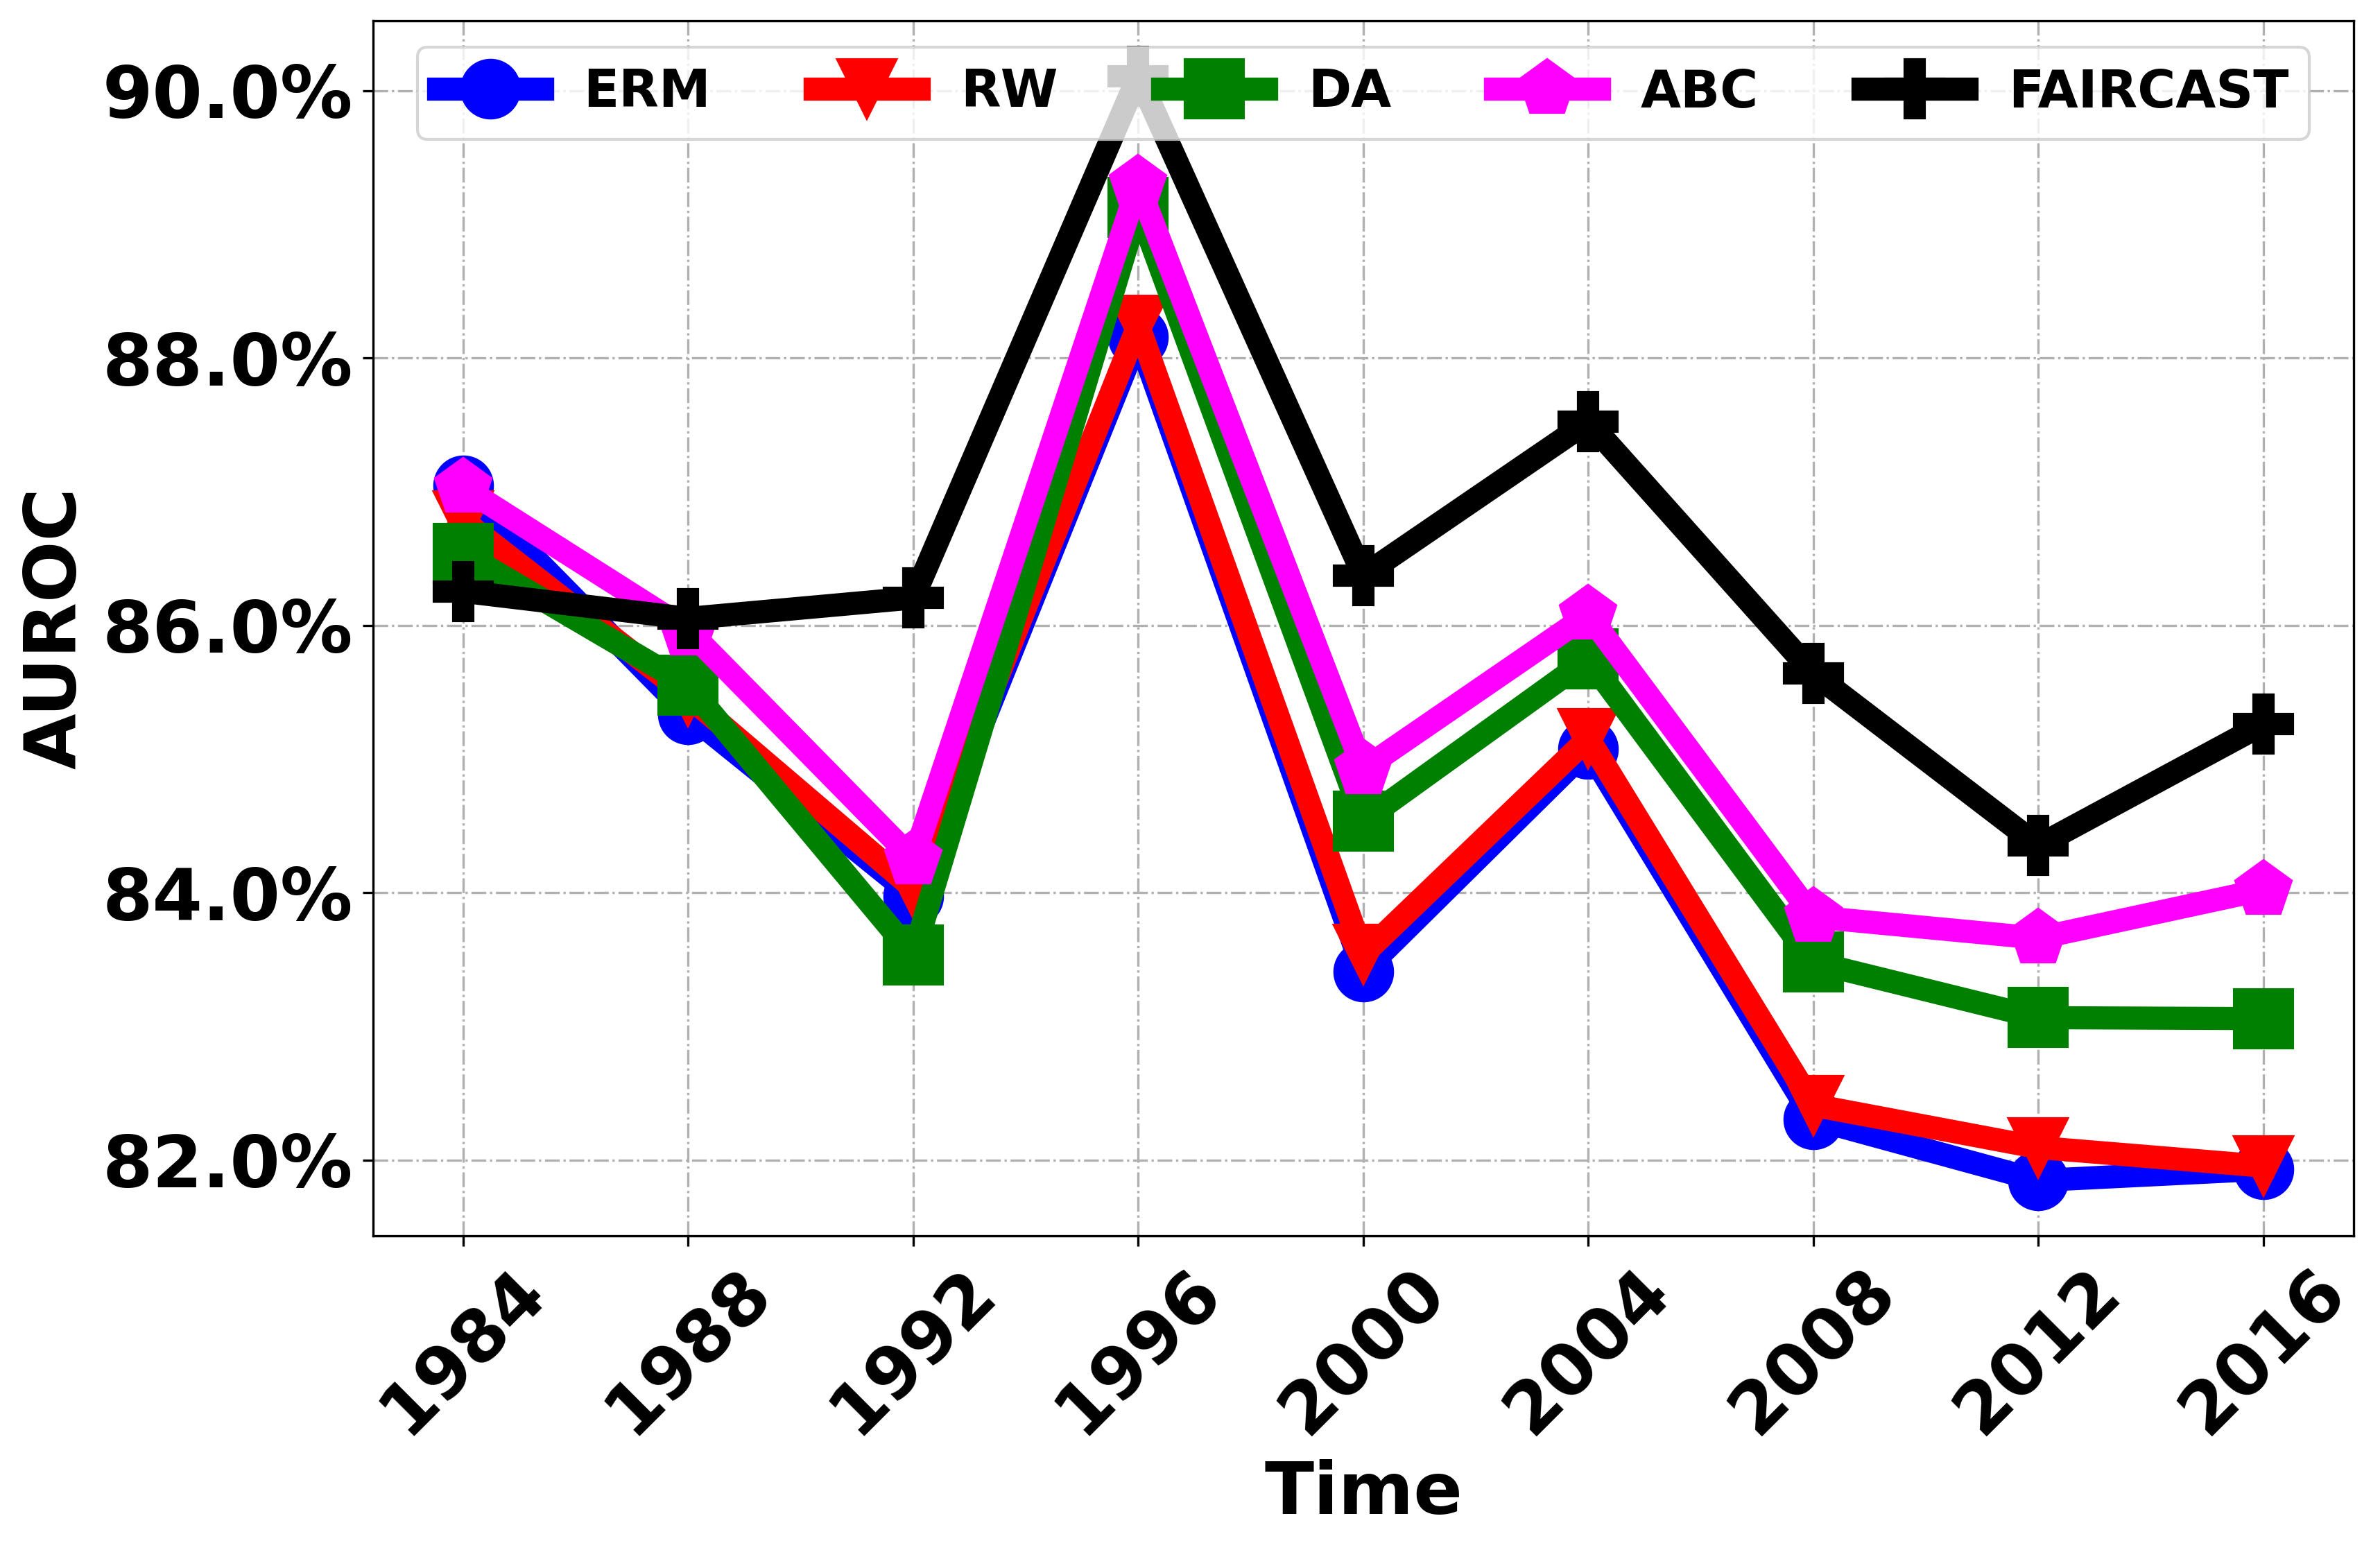

In [30]:
temporal_plotting('auc', 'AUROC')

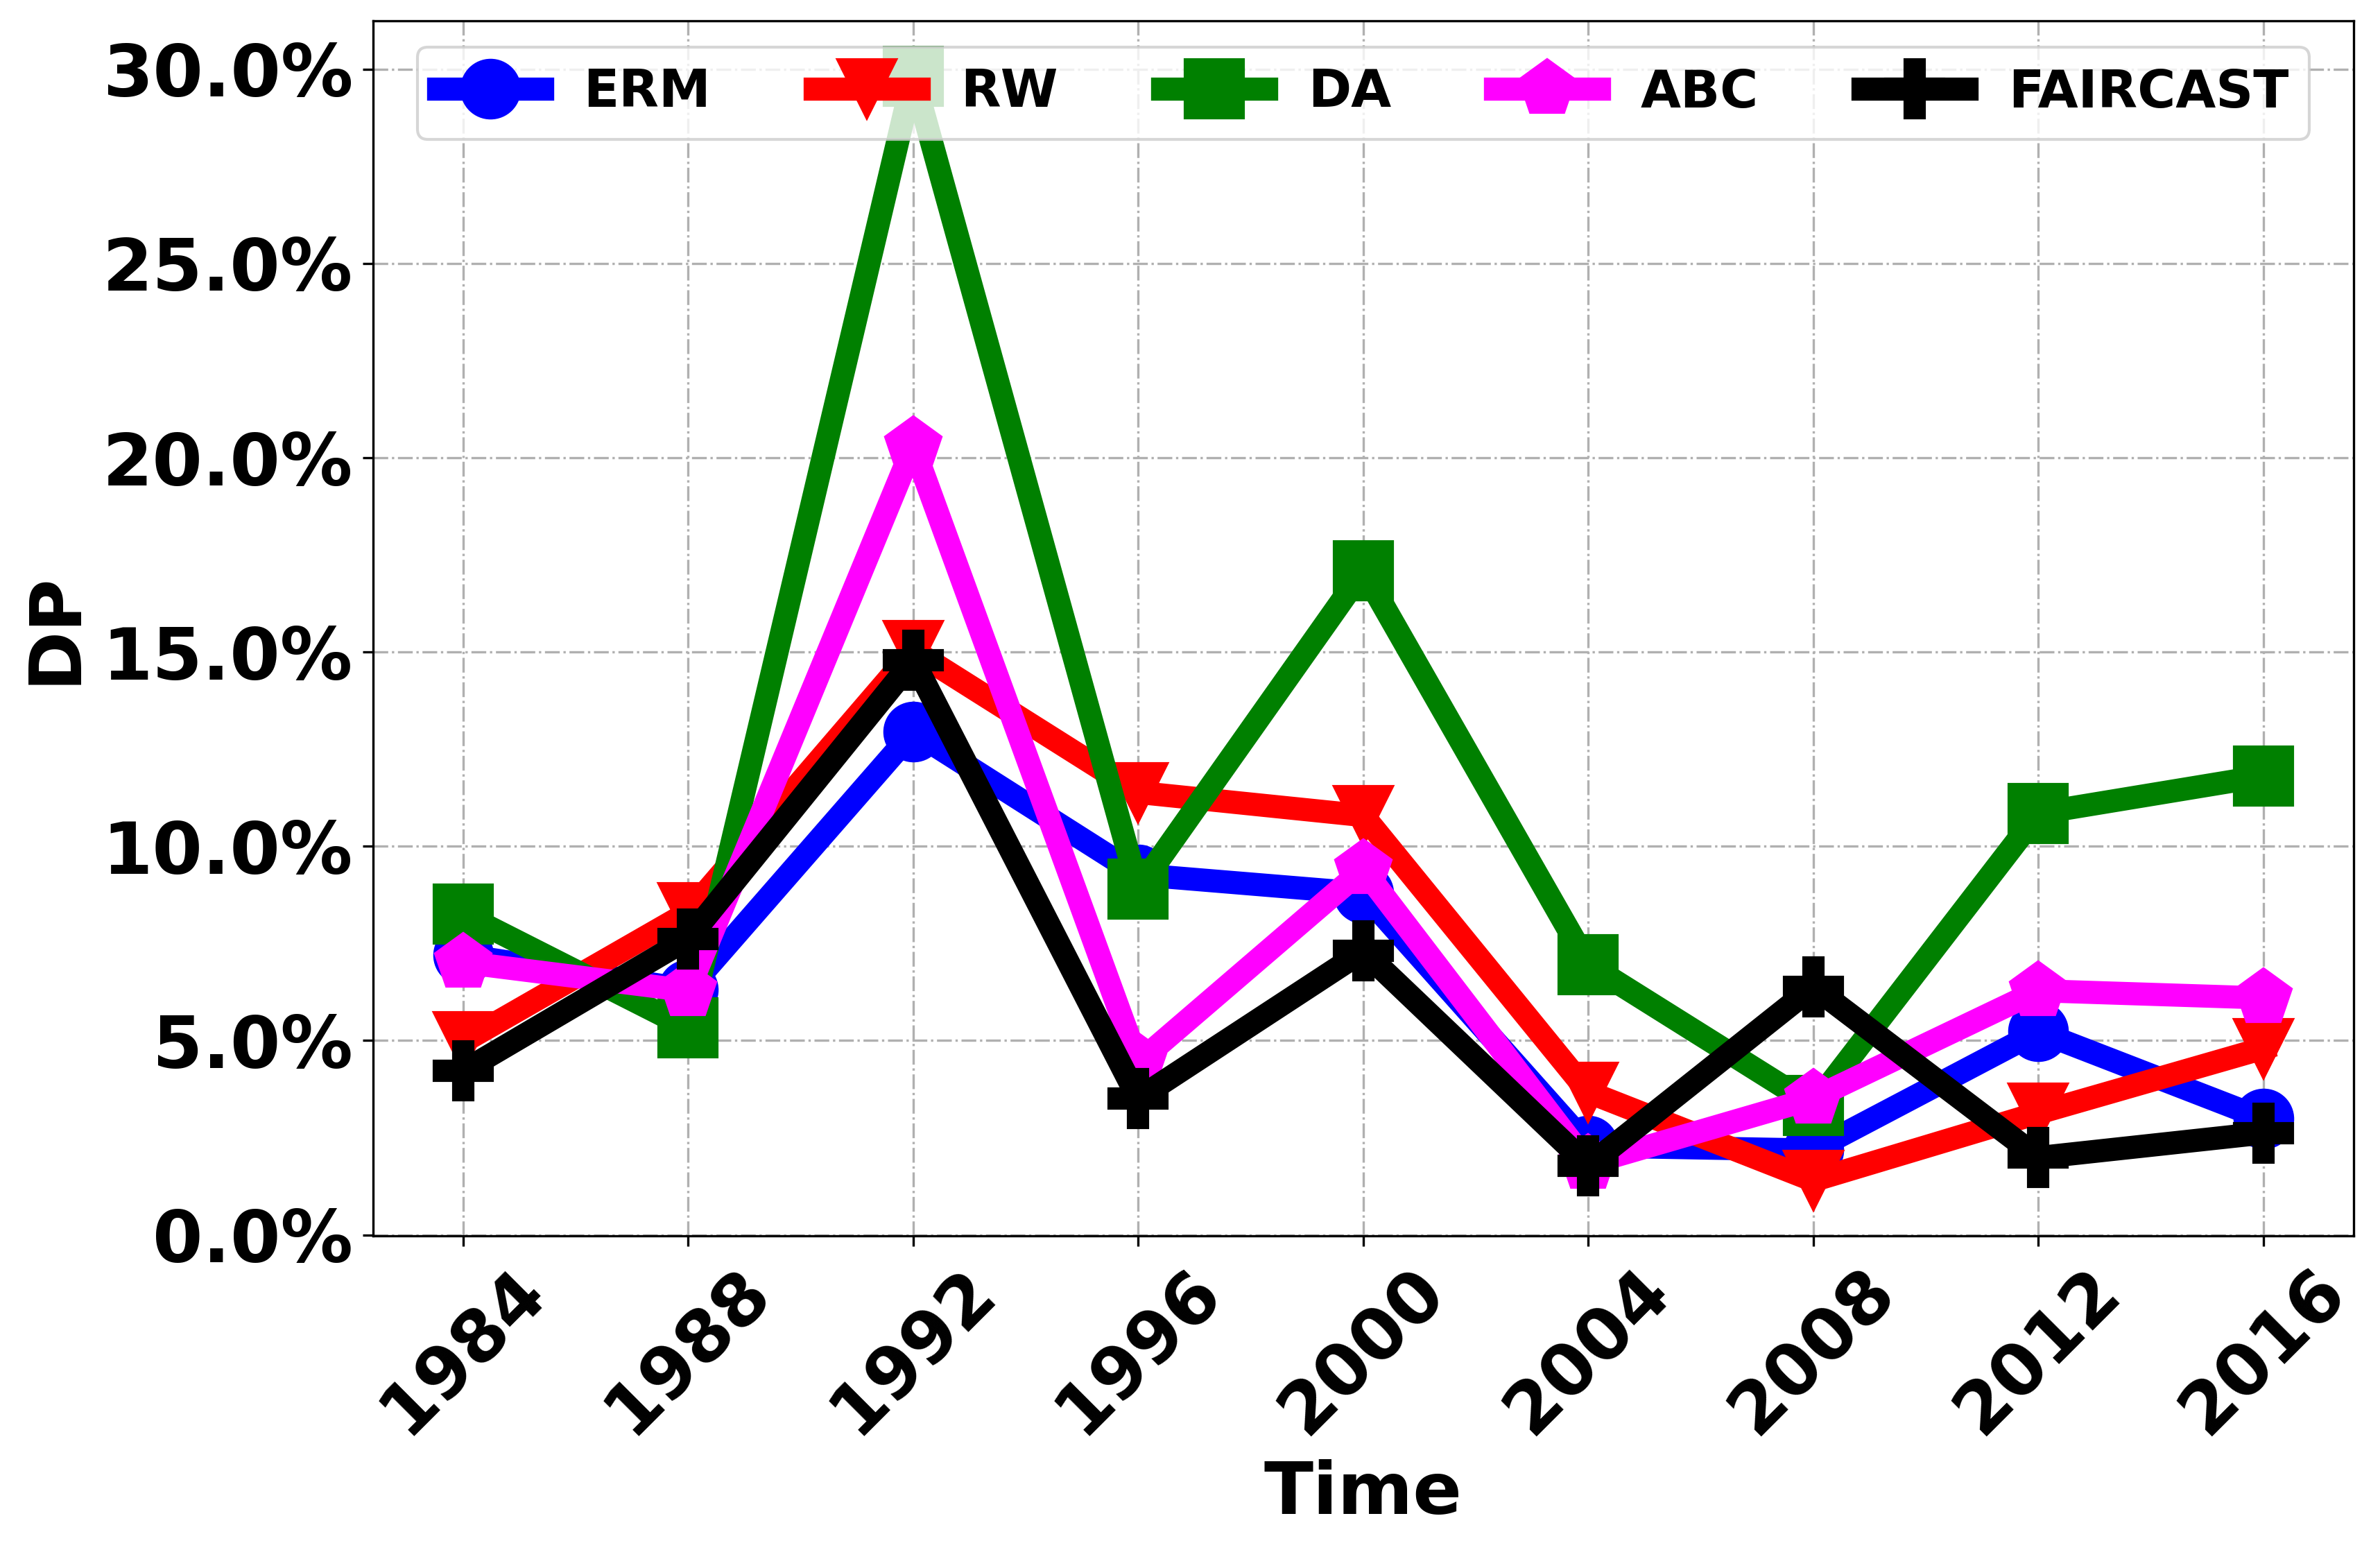

In [31]:
temporal_plotting('spd', 'DP')

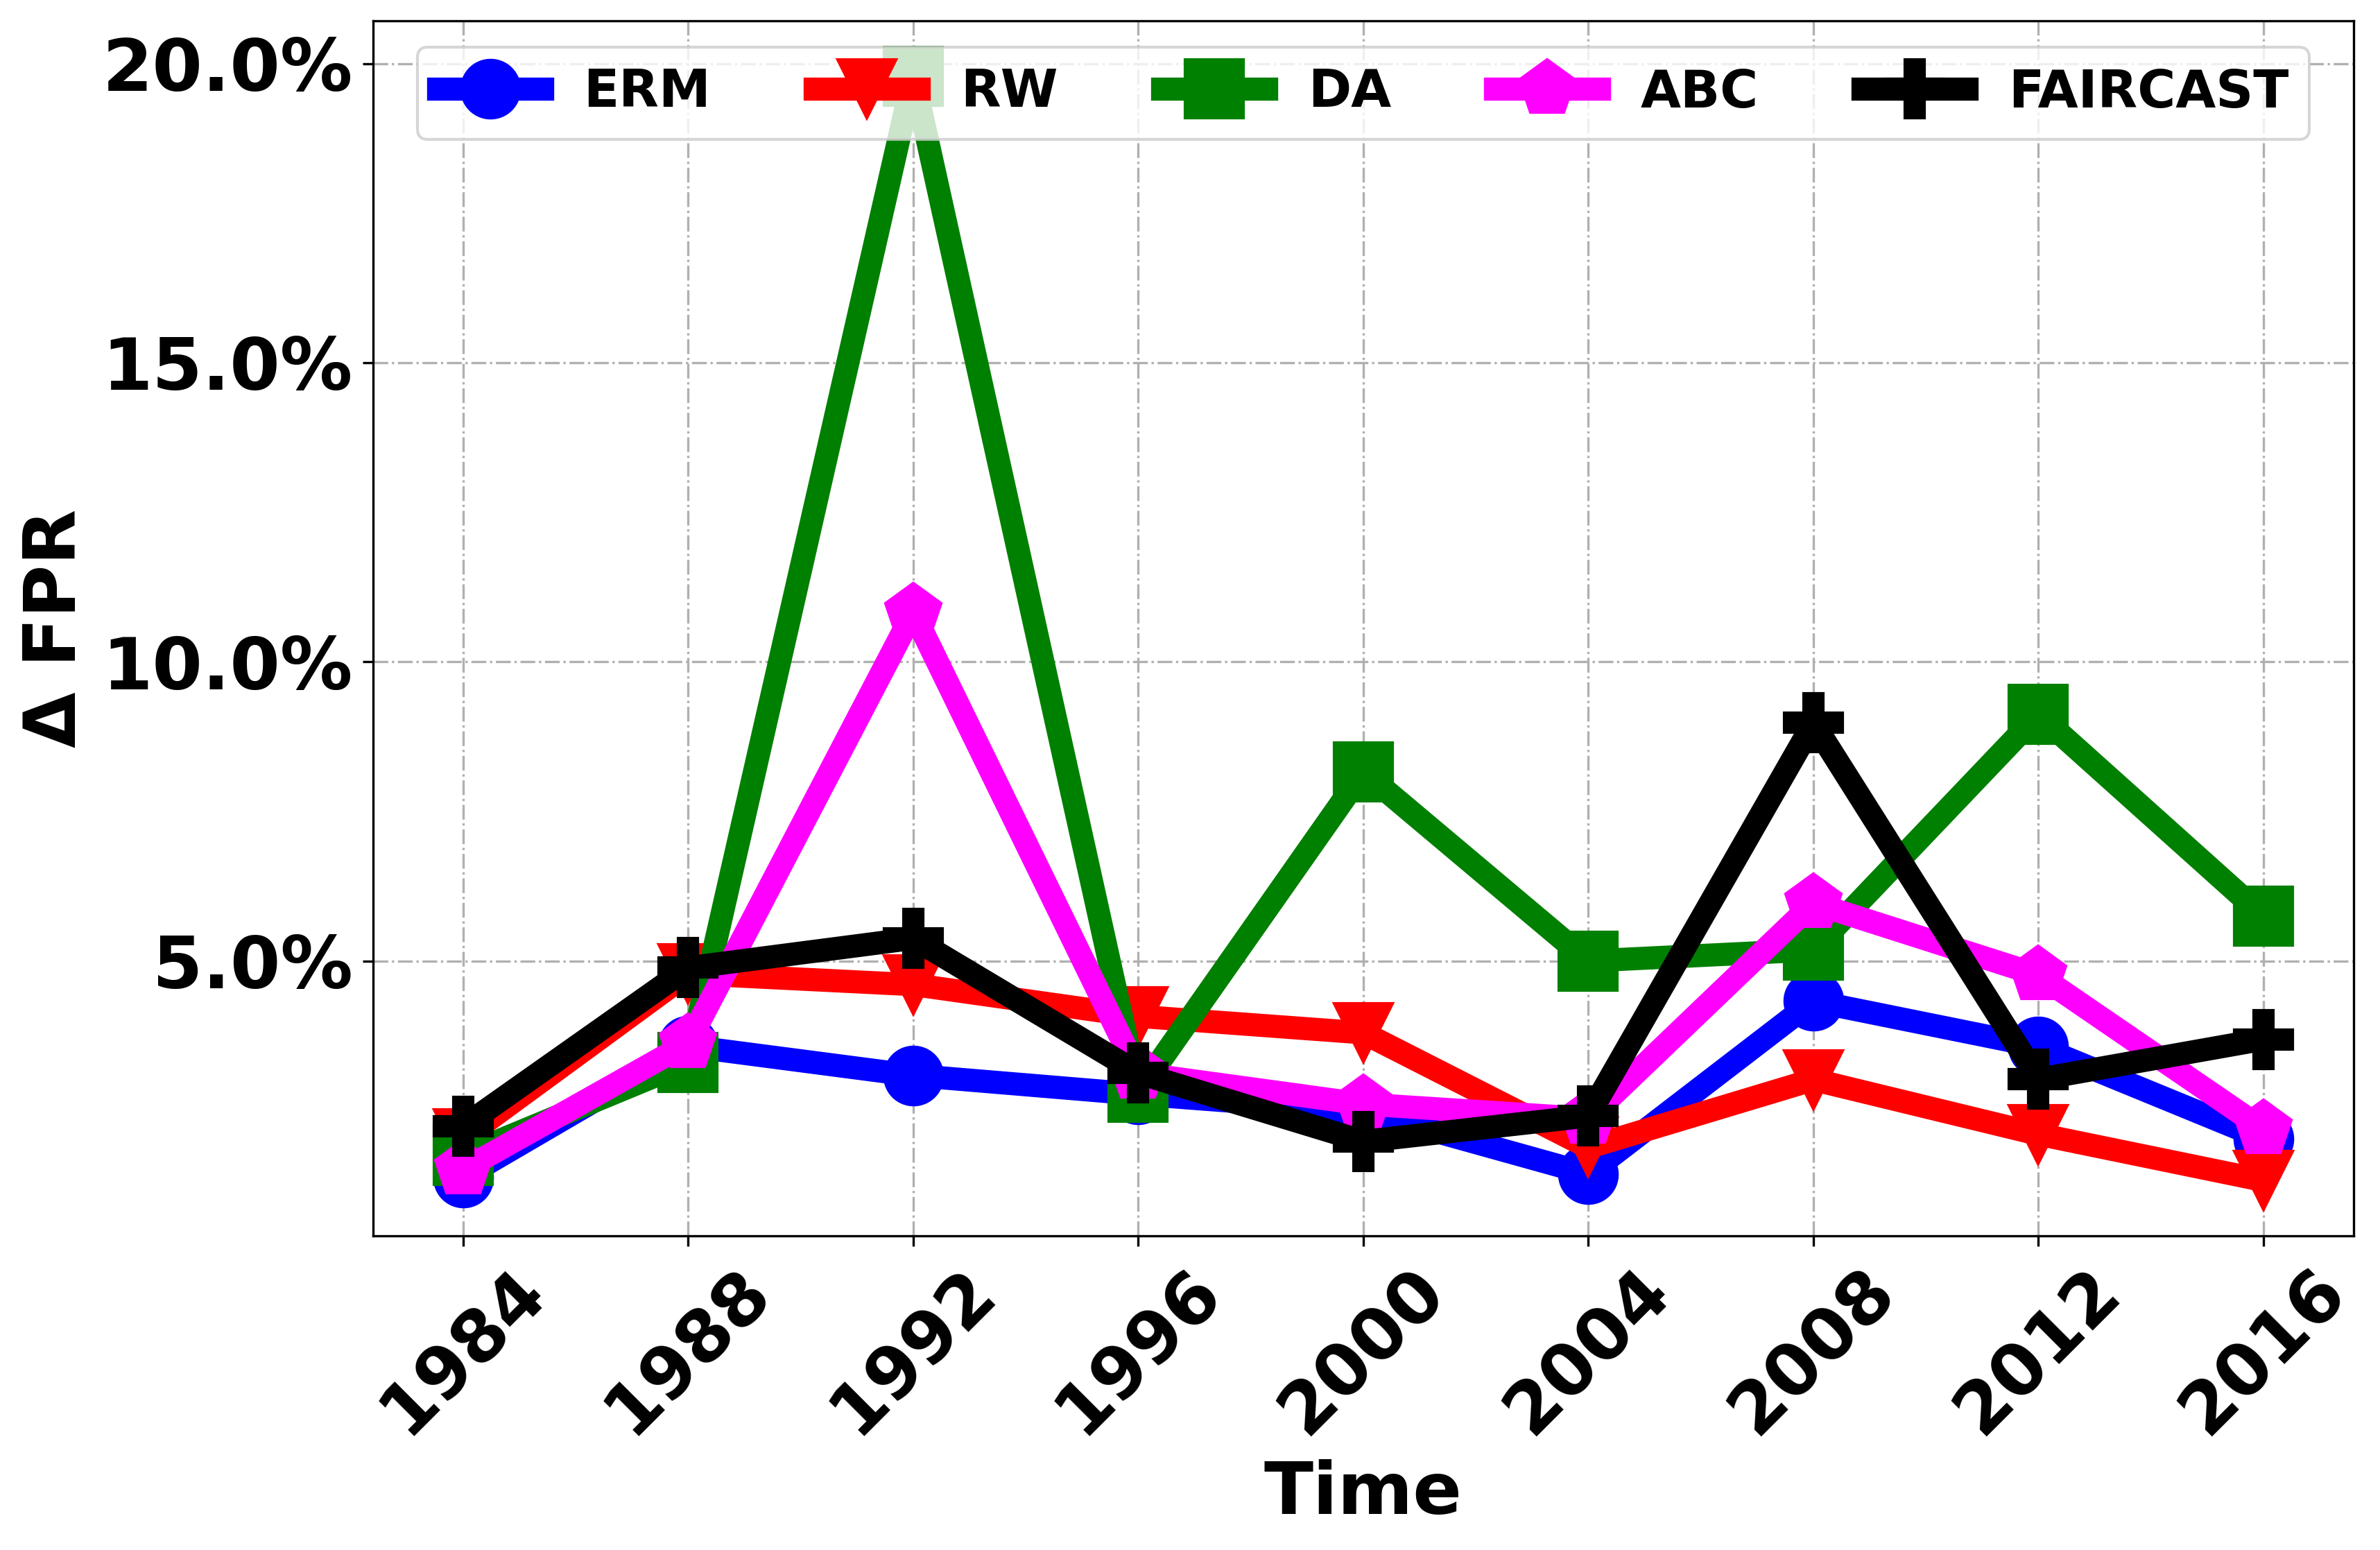

In [32]:
temporal_plotting('fprd', 'Δ FPR')

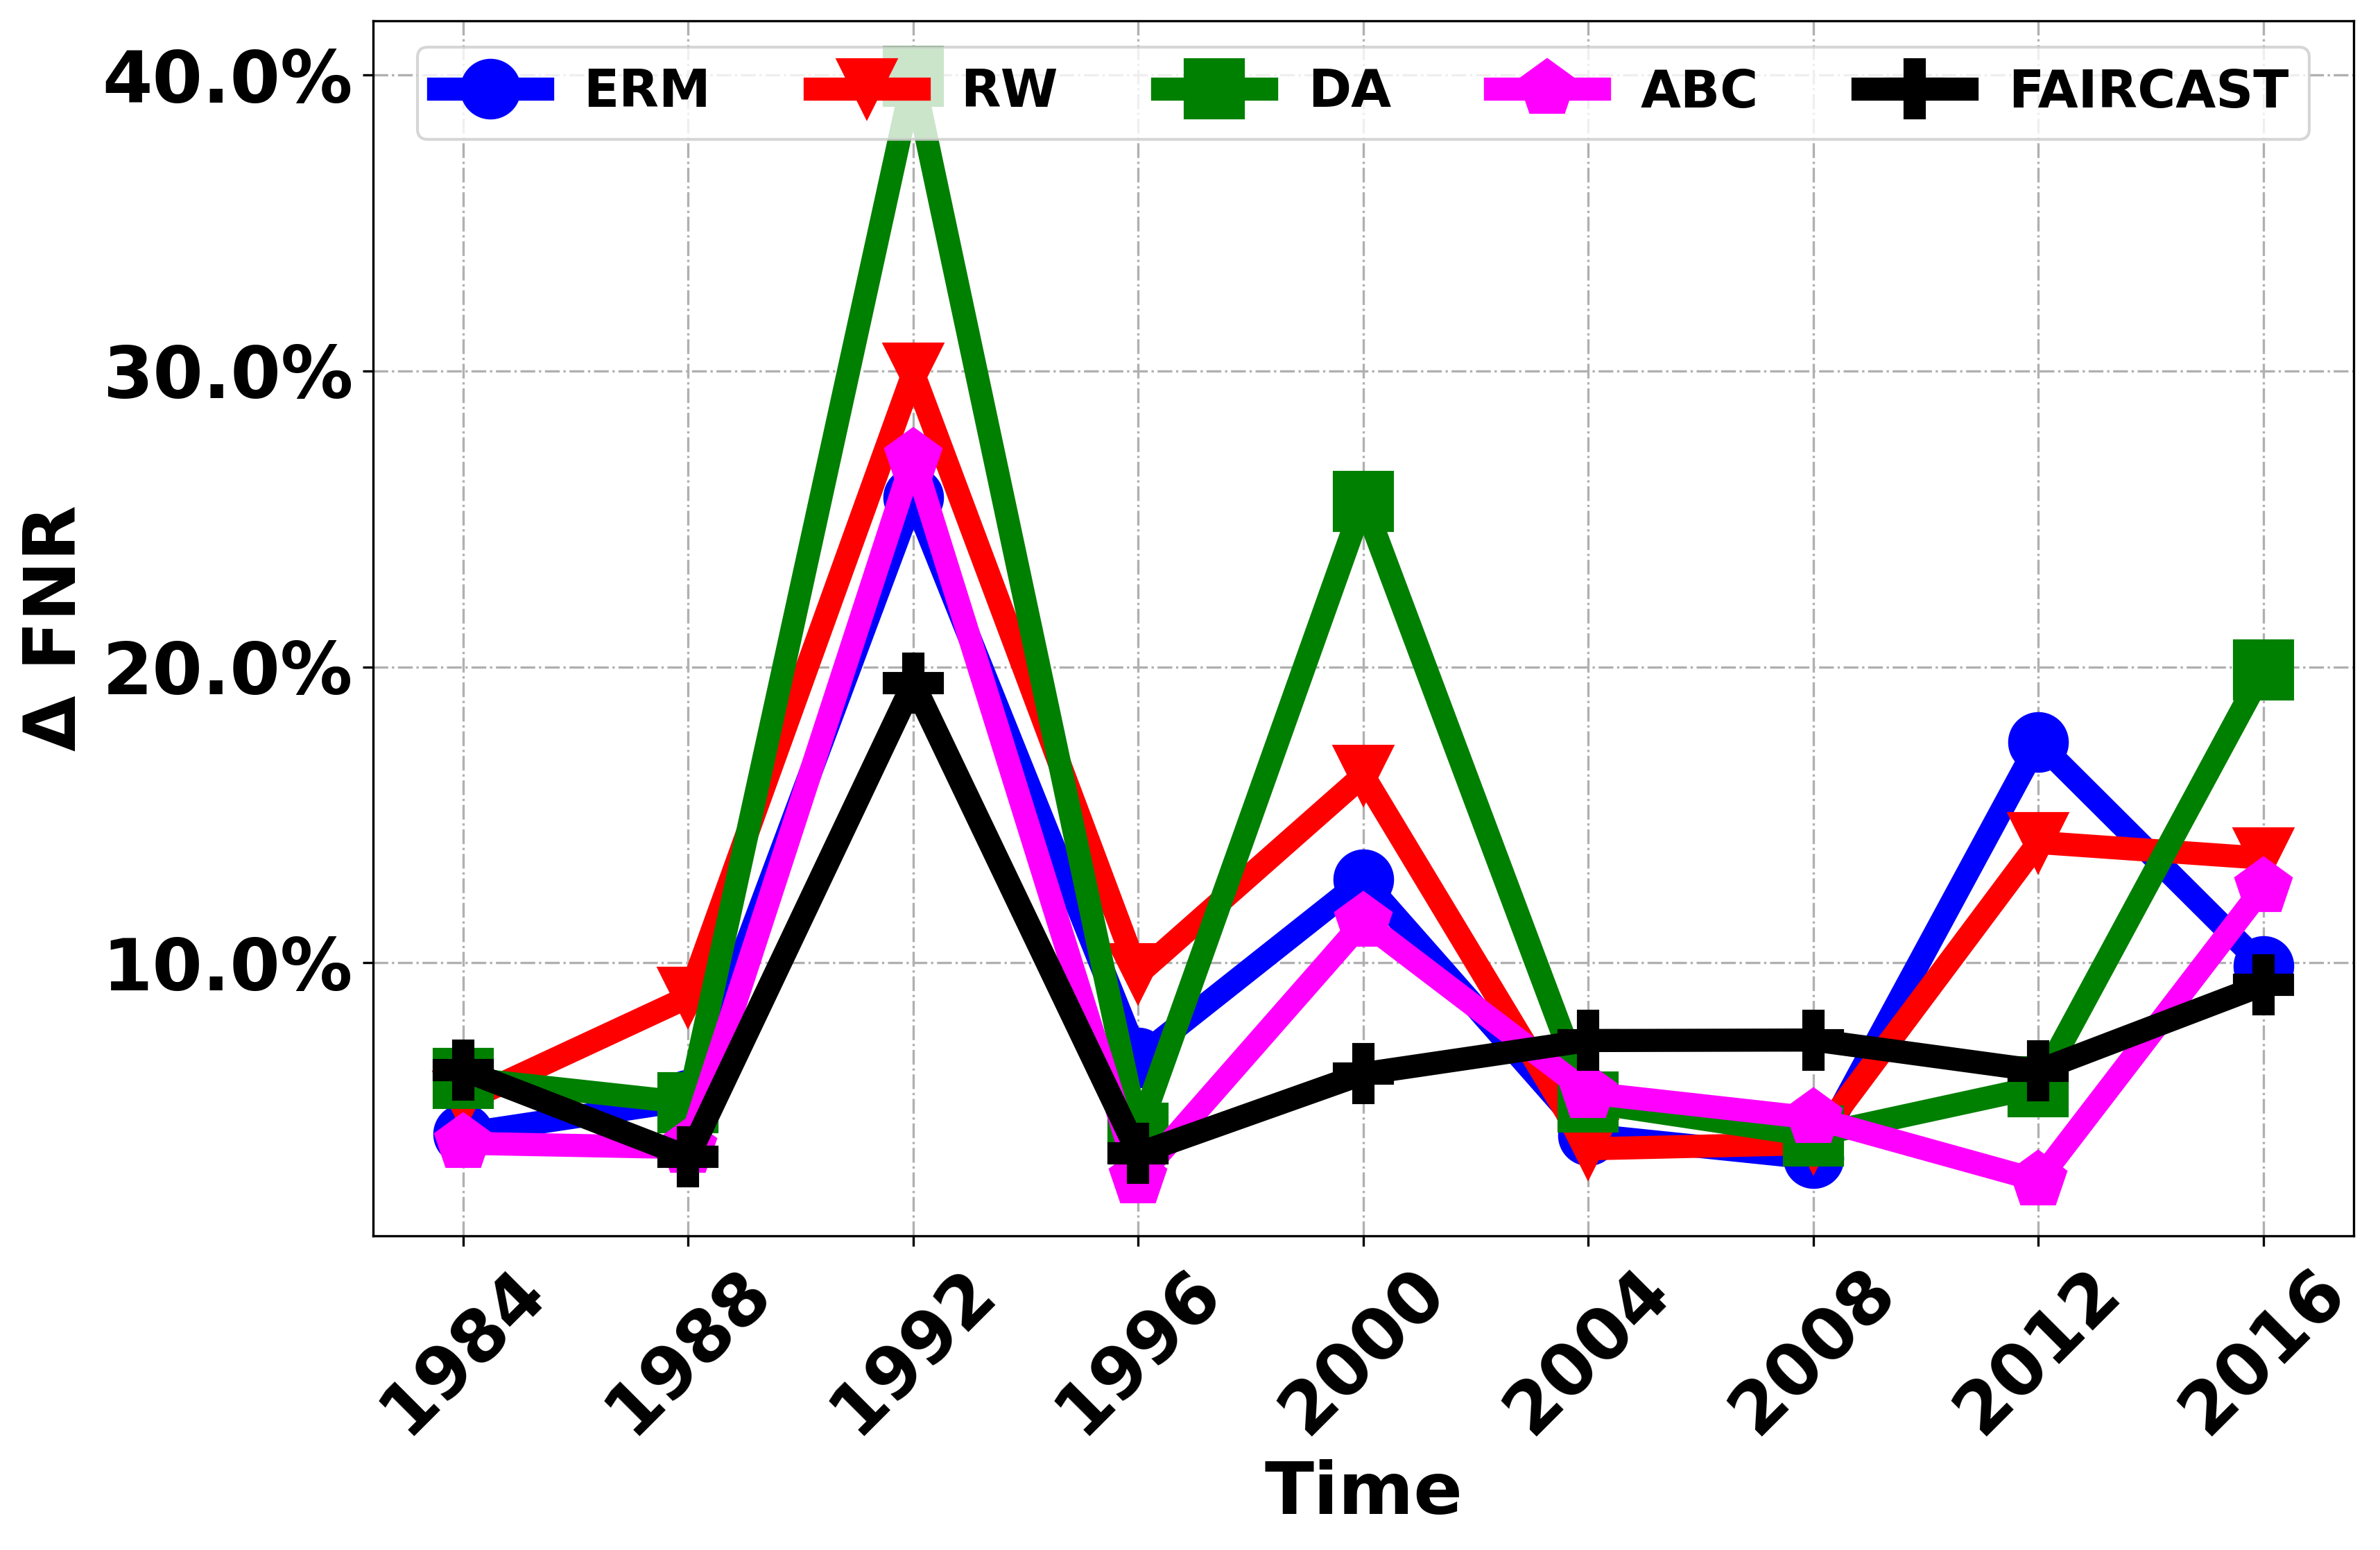

In [33]:
temporal_plotting('fnrd', 'Δ FNR')

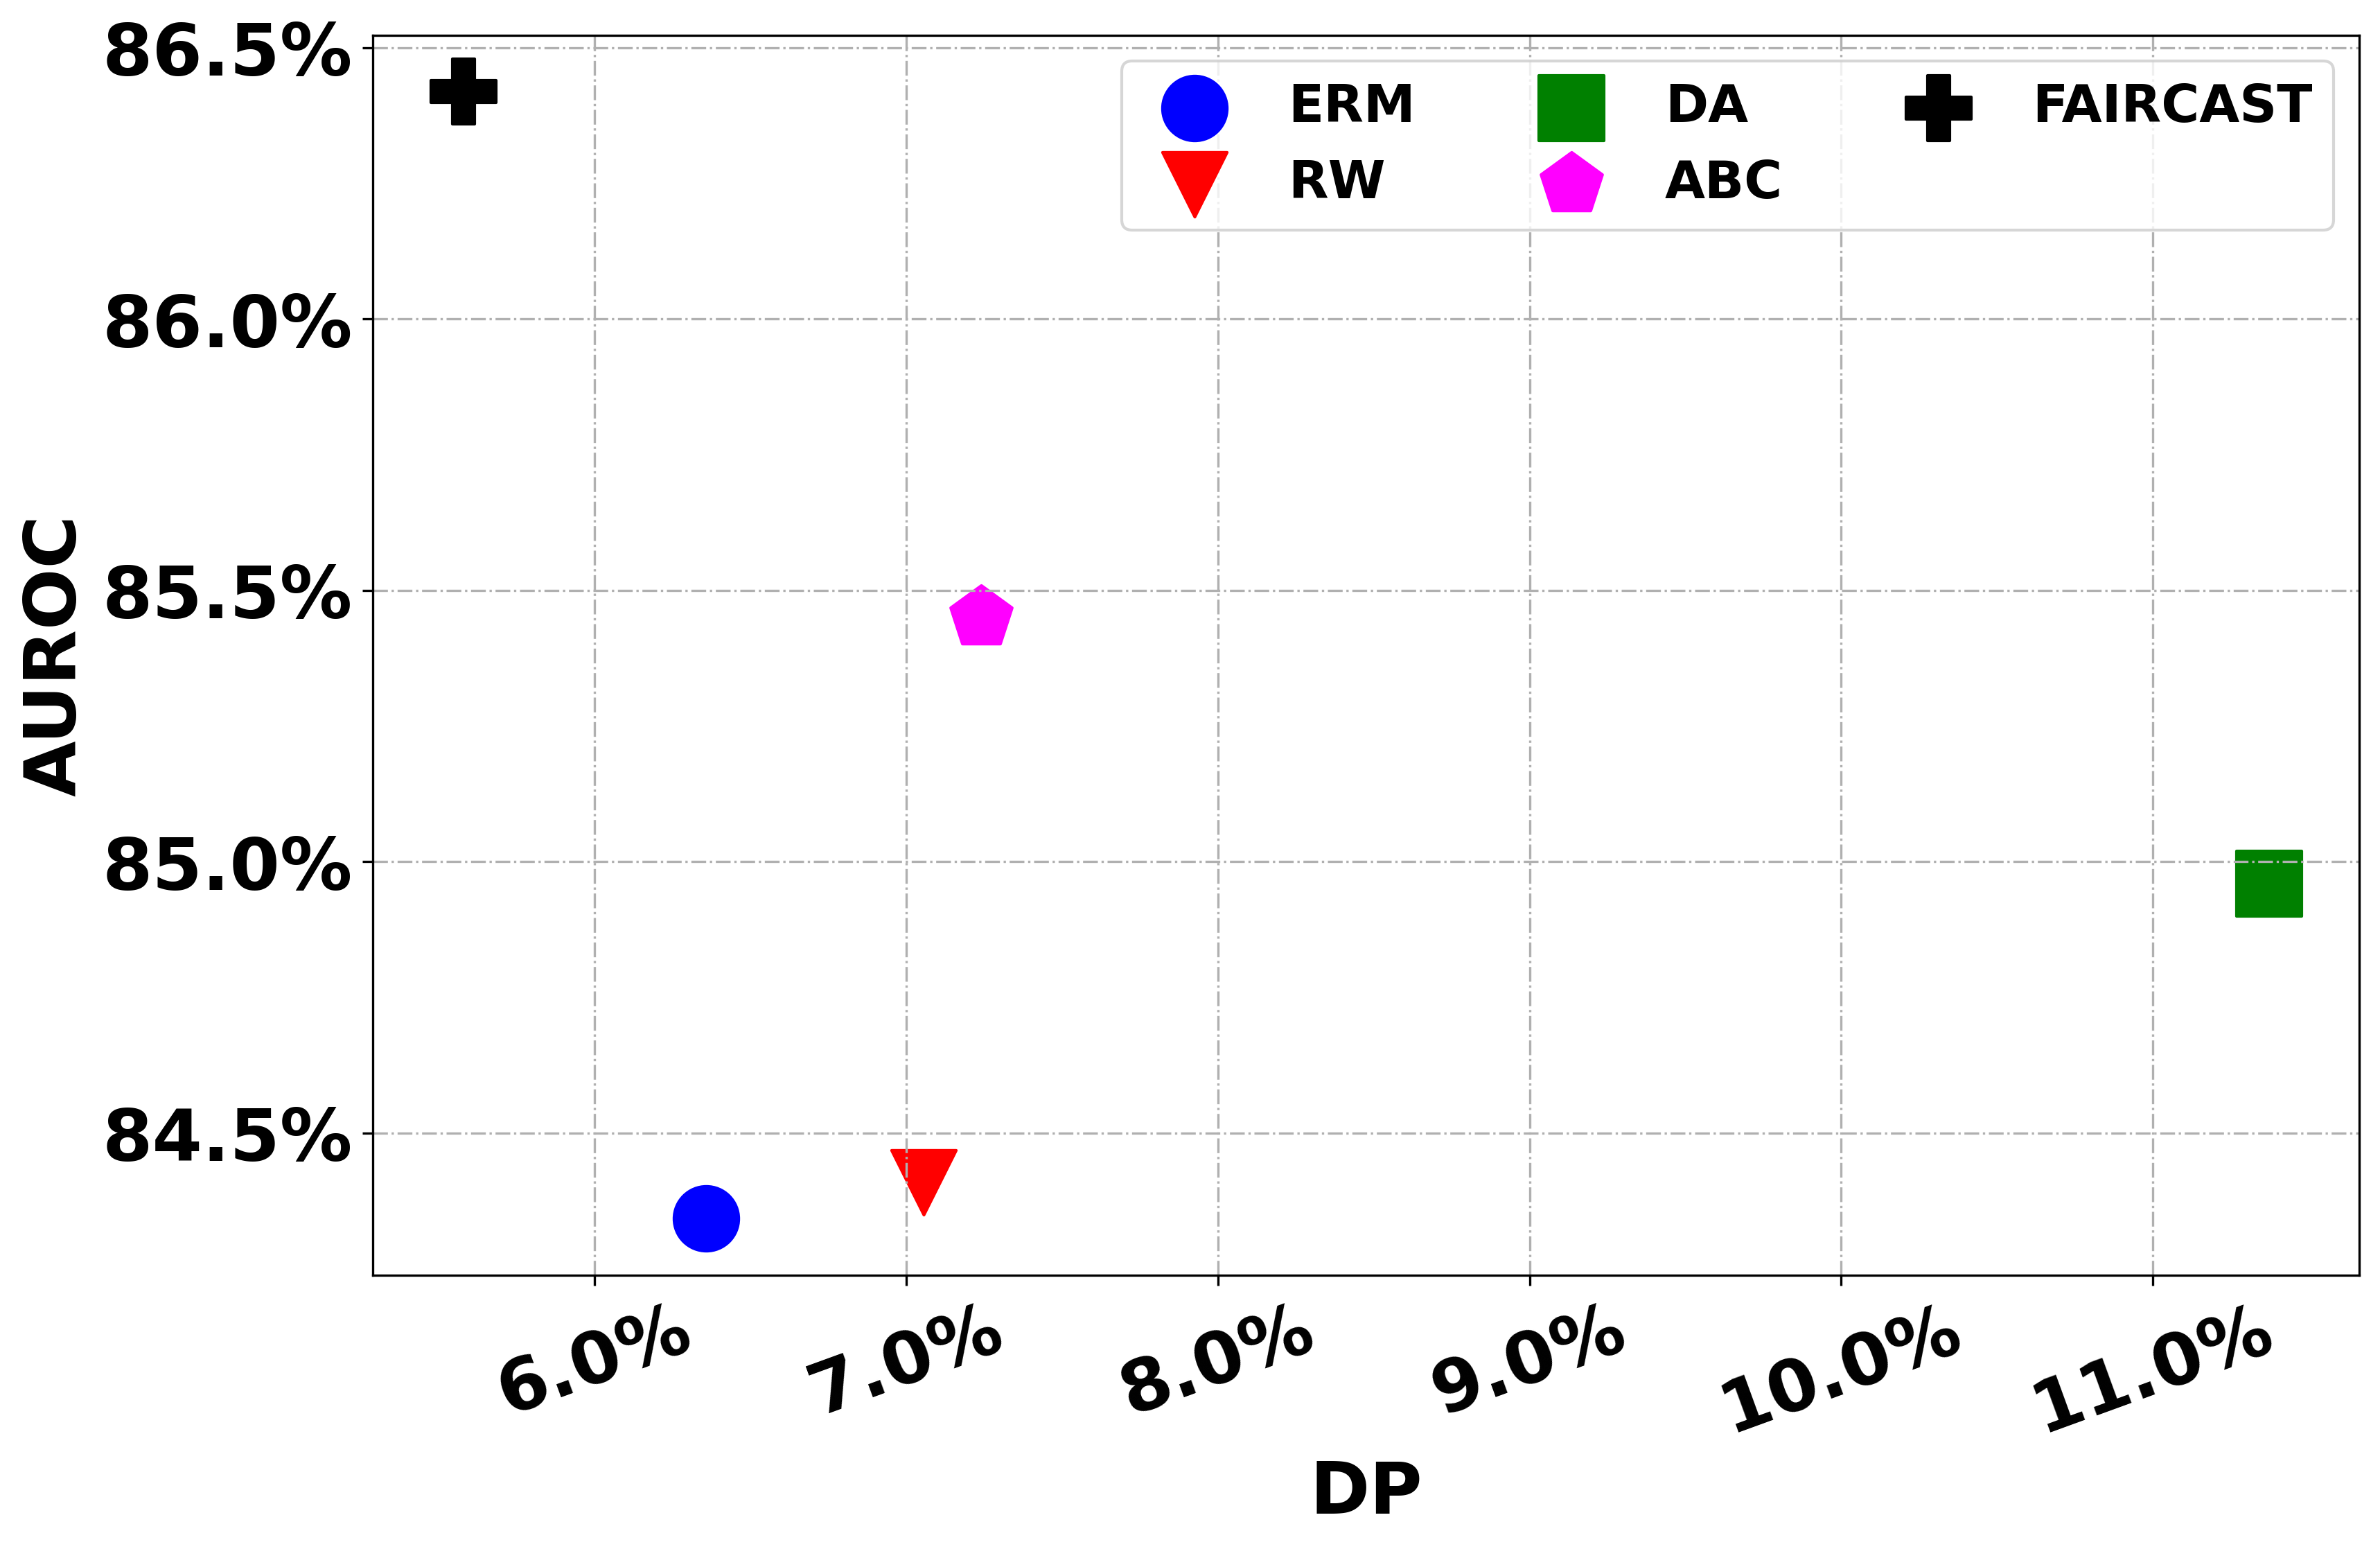

In [34]:
plotting('spd','auc', 'DP', 'AUROC')

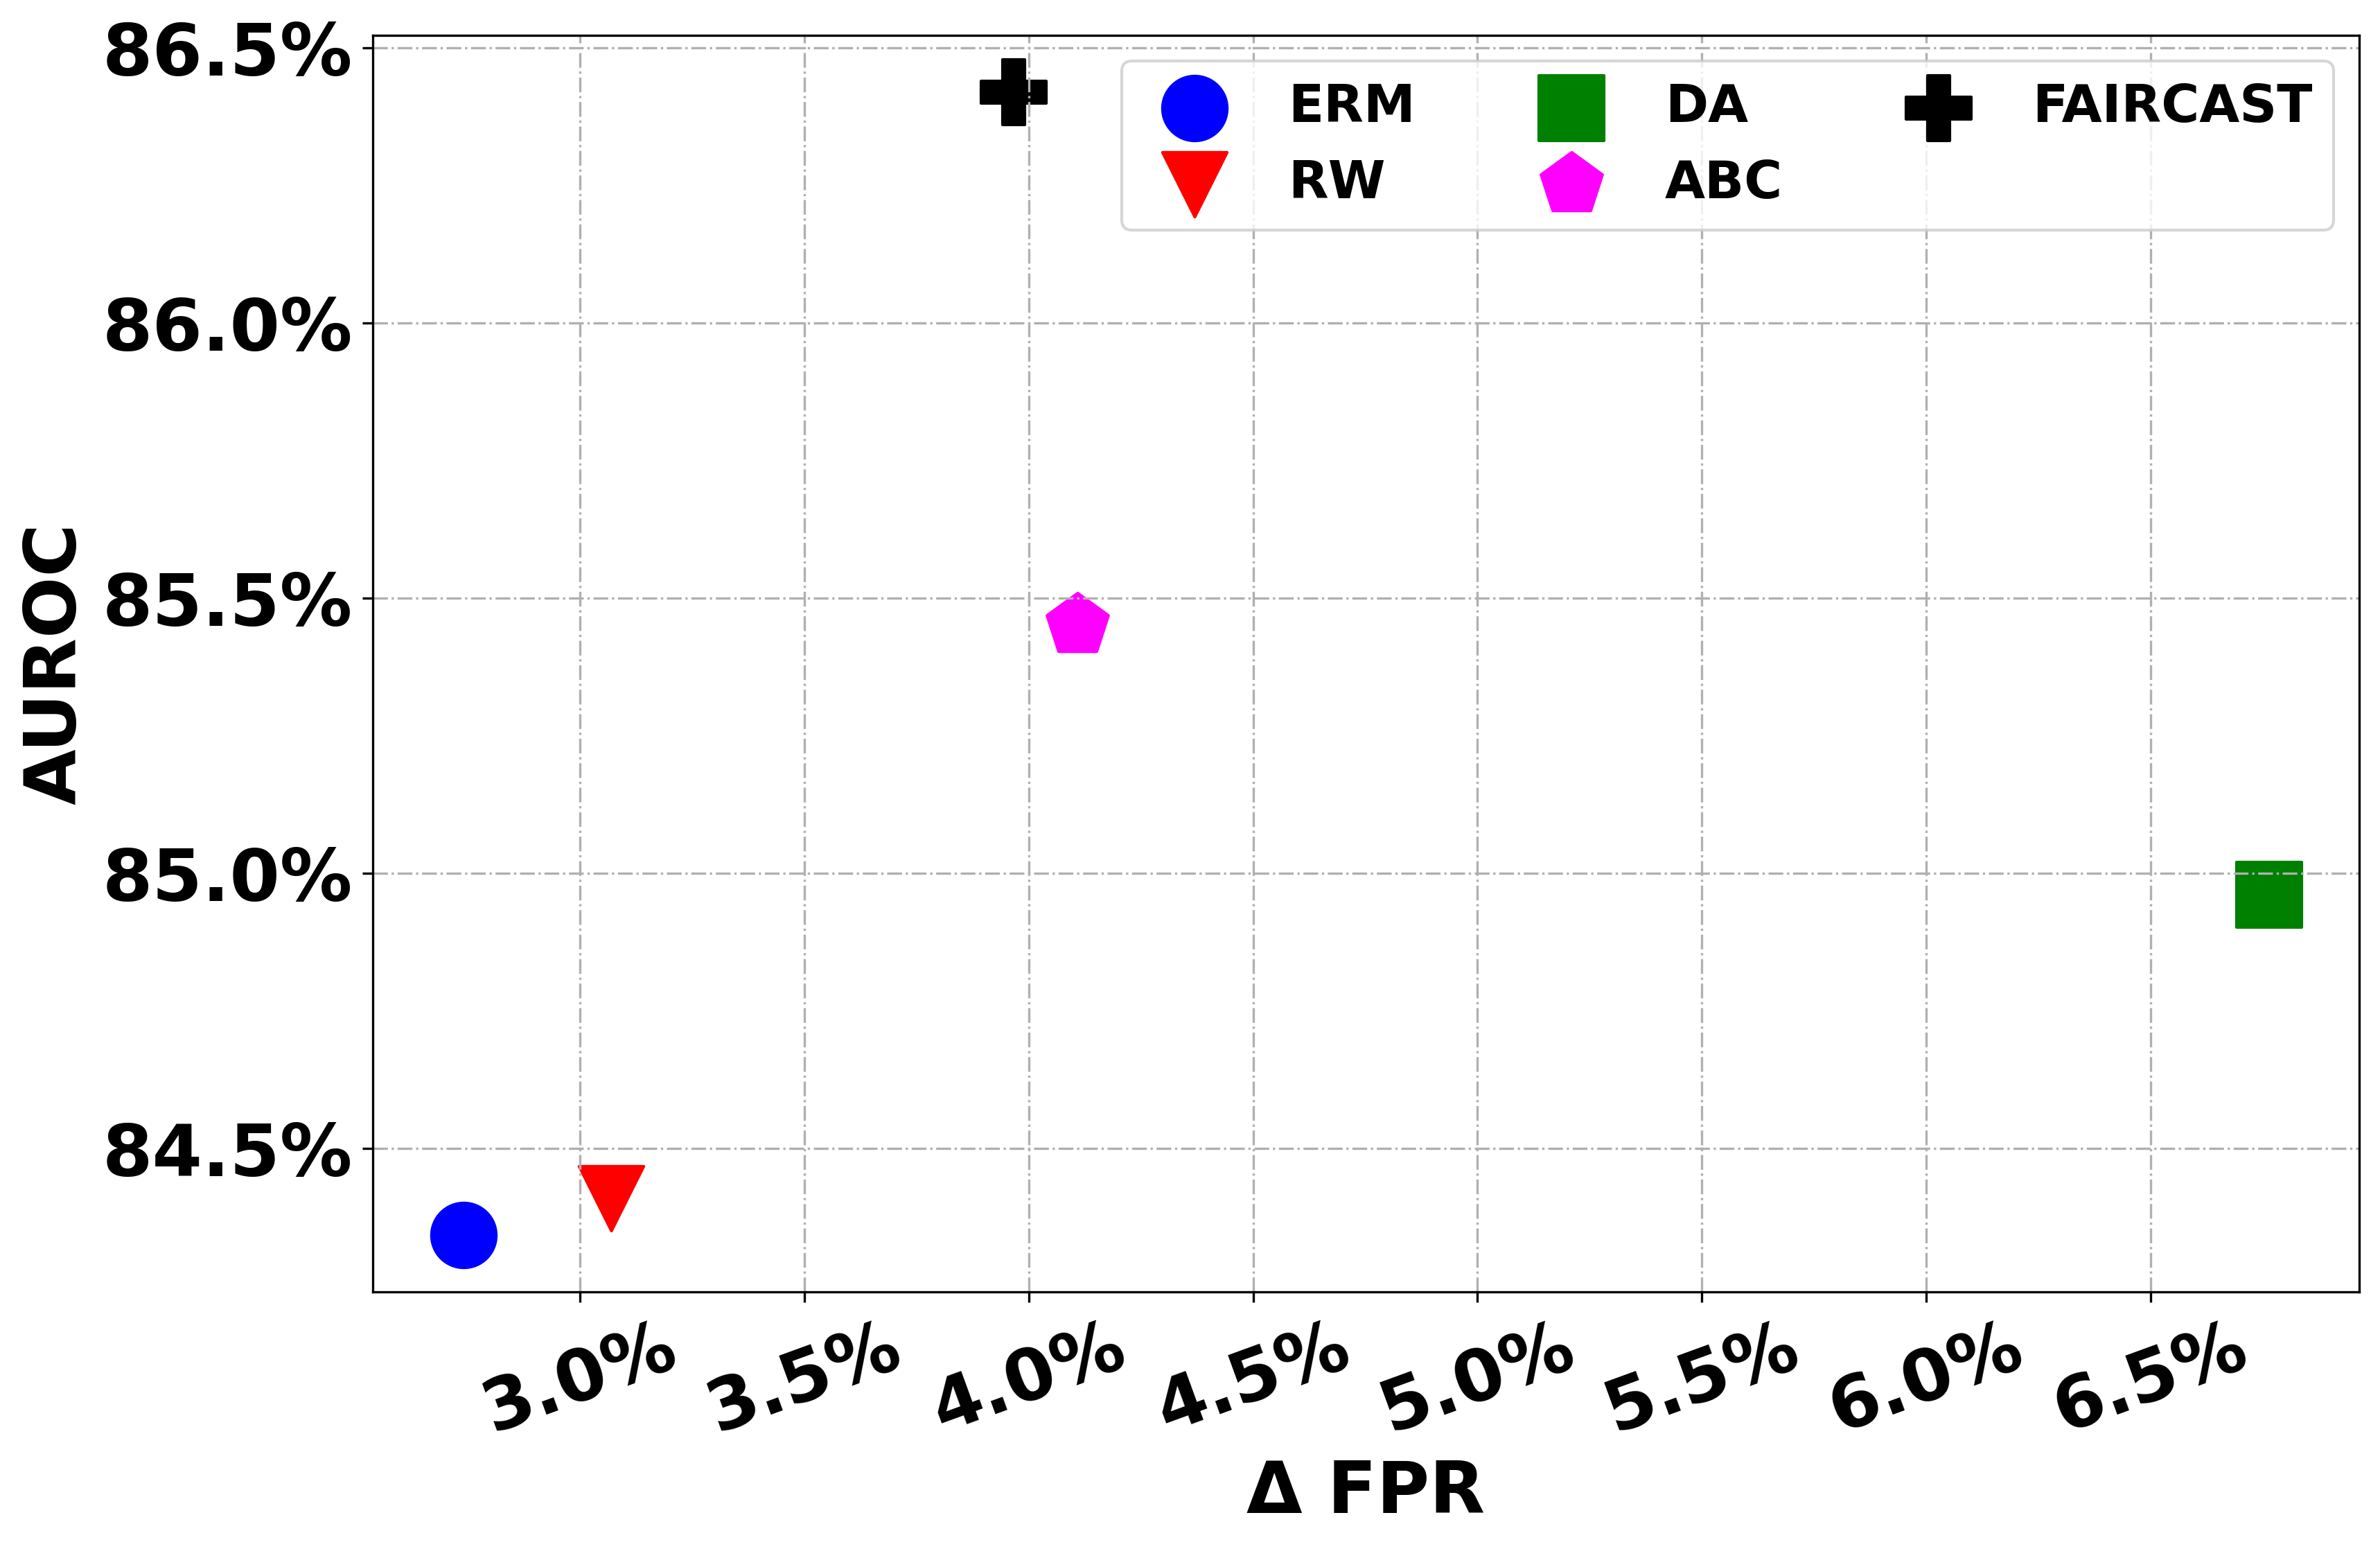

In [35]:
plotting('fprd','auc', 'Δ FPR', 'AUROC')

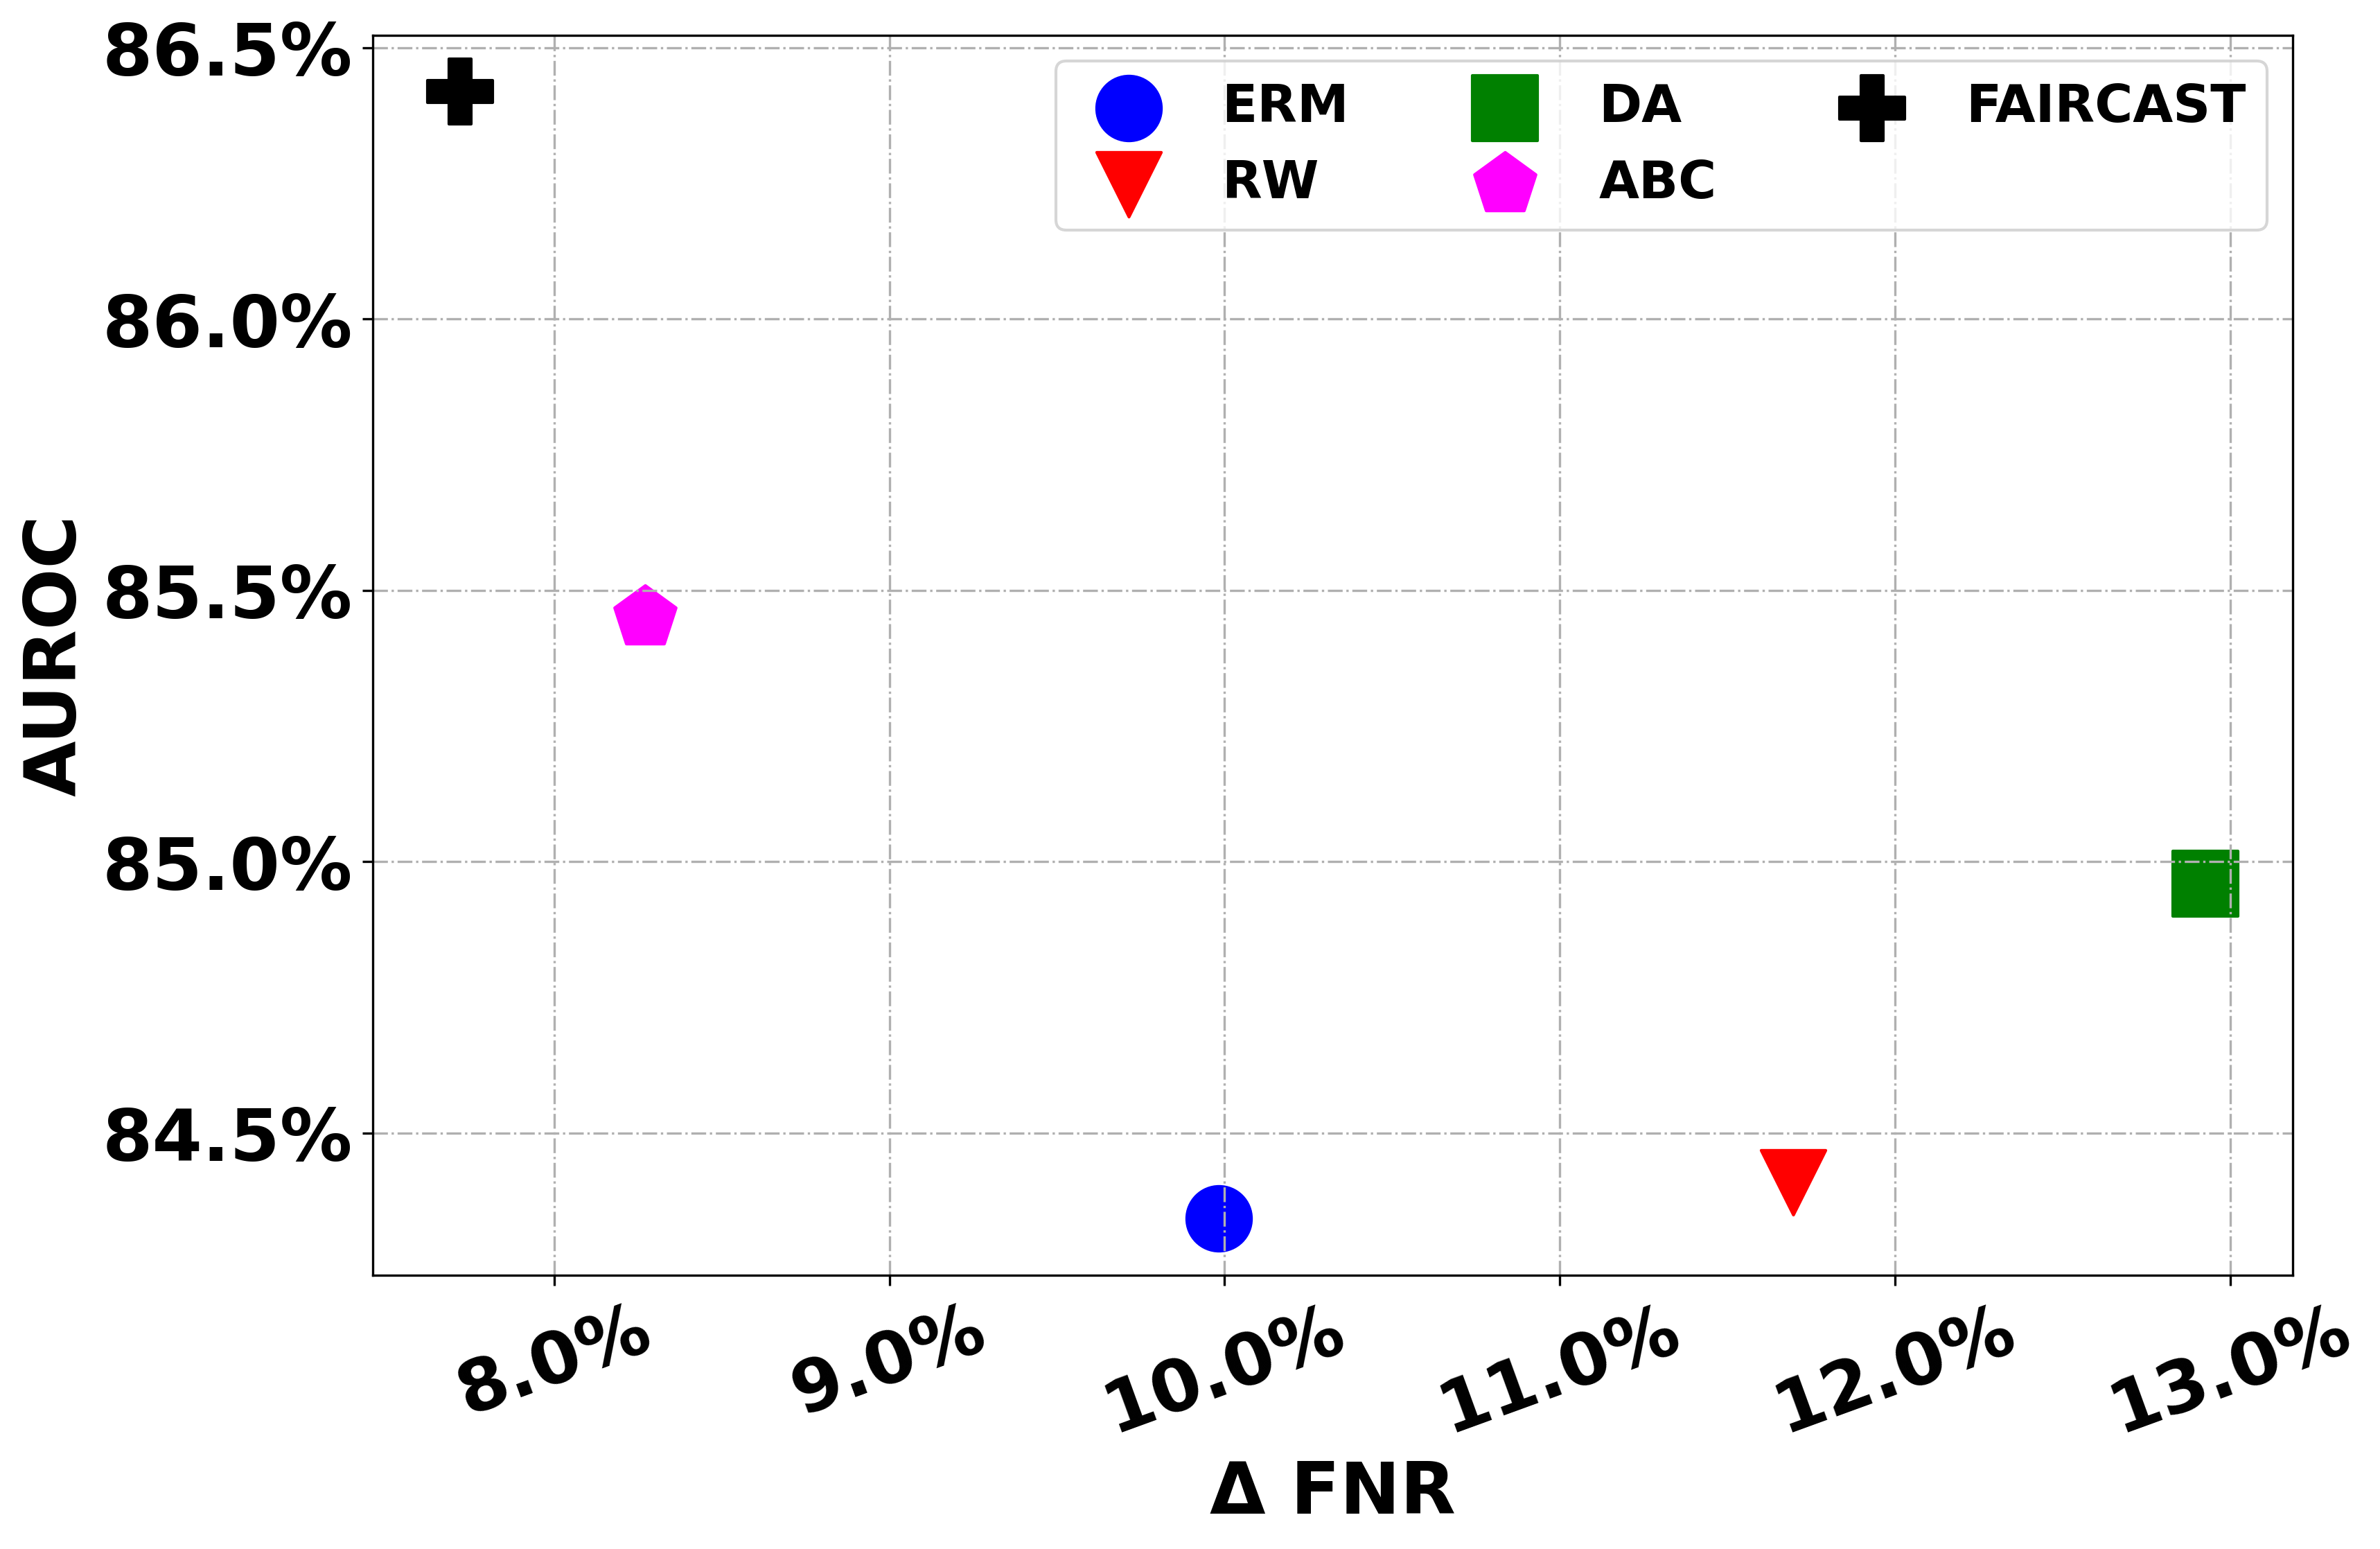

In [36]:
plotting('fnrd','auc', 'Δ FNR', 'AUROC')

In [ ]:
plotting('delta_auc','auc', 'Δ AUROC', 'AUROC')

In [ ]:
# plotting('S0_auc','S1_auc', 'Disadvantaged Group (AUROC)', 'Advantaged Group (AUROC)')

In [ ]:
plotting_ablation('spd','auc', 'DP', 'AUROC')

In [ ]:
plotting_ablation('fprd','auc', 'Δ FPR', 'AUROC')

In [ ]:
plotting_ablation('fnrd','auc', 'Δ FNR', 'AUROC')

In [ ]:
plotting_ablation('delta_auc','auc', 'Δ AUROC', 'AUROC')

In [ ]:
# plotting_ablation('S0_auc','S1_auc', 'Disadvantaged Group (AUROC)', 'Advantaged Group (AUROC)')

### Estimation Error

In [ ]:
metric = 'estimation_error'


ind = np.arange(len(results['da'][0][metric]))  # the x locations for the groups
width = 0.4  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind - width/2, results['da'][0][metric], width, yerr=results['da'][1][metric],
                label='DA', color ='green')
rects2 = ax.bar(ind + width/2, results['almuzaini'][0][metric], width, yerr=results['almuzaini'][1][metric],
                label='ABC', color ='magenta')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Estimation Error', fontweight='bold')
ax.set_xticks(ind)
ax.set_xticklabels(years[2:], rotation=45, ha='right', fontweight = 'bold')
ax.set_yticklabels(ax.get_yticks().round(2), weight='bold')
ax.set_xlabel('Time', fontweight='bold')
ax.legend(prop = {'weight' : 'bold'})

plt.tight_layout()
plt.savefig(f'./results/ablation_{name}-{metric}.png')

### DTO

In [ ]:
results_df = utils.create_data_frame_results(results)

In [ ]:
results_df = results_df[results_df['Methods'].isin(['vanilla', 'fairness', 'da', 'almuzaini', 'ours_spd'])]

In [ ]:
utils.DTO(results_df, 'spd').round(3)

In [ ]:
utils.DTO(results_df, 'fprd').round(3)

In [ ]:
utils.DTO(results_df, 'fnrd').round(3)

In [ ]:
utils.DTO(results_df, 'delta_auc').round(3)

### RandomSplits

In [ ]:
from sklearn.model_selection import train_test_split
def random_splits(data):
    all_results = []
    df = data.drop('year', axis=1)
    for i in range(10):
        new_df = df.sample(frac=1).reset_index(drop=True)
        new_df = new_df.sample(10000)
        X, y = new_df.drop('y', axis=1), new_df['y'].values
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, stratify=y)

        train = X_train.copy()
        train['y'] = y_train
        instance_weights = utils.kamiran(train, 'sensitive', 'y', verbose=True)
    
        model = get_model('LR-Balanced')
    
        model.fit(X_train, y_train, sample_weight = instance_weights)
    
        pred = model.predict(X_test)
        prob = model.predict_proba(X_test)[:, 1]
    
        results = utils.get_results(X_test['sensitive'].values, y_test, pred, prob)
        all_results.append(results)
    
    final_results = pd.DataFrame(all_results)
    final_results.columns = names

    return final_results.mean(), final_results.std()

random_mean, random_std = random_splits(data)
random_mean[['auc','spd','fprd', 'fnrd', 'delta_auc']] * 100